# Variance Ellipses

In this lab, you'll be working with current meter data, that is, observations of the horizontal ocean currents made from a fixed point. The main analysis tool we will learn are variance ellipses, a fundamental tool for analyzing velocity datasets or any kind of bivariate (or complex-valued) data.  You'll see their relationship to the two-dimensional histogram, and will learn some associated analysis and visualization ideas, in particular the value of finding a suitable coordinate rotaiton. 

For this assignment, we are going to use a mooring from the Labrador Current on the west side of the Labrador Sea known as the ‘m1244’ mooring. Please download my version of it [here](https://www.dropbox.com/s/yvffwaspom6p443/m1244.mat?dl=0) if you have not done so already. (This is included in the full distribution of the course materials from Github.)

In [1]:
#Install packages we will need ... set this to true your first time running the notebook
if false
    using Pkg
    Pkg.add("BenchmarkTools")
    Pkg.add("CairoMakie")
    Pkg.add("ColorSchemes")
    Pkg.add("DataFrames")
    Pkg.add("Dates")
    Pkg.add("DayCounts")
    Pkg.add("DSP")
    Pkg.add("ImageFiltering")
    Pkg.add("Interpolations")
    Pkg.add("LinearAlgebra")
    Pkg.add("NaNStatistics")
    Pkg.add("NetCDF")
    Pkg.add("StatsBase")
    Pkg.add("TickTock")
    Pkg.add("VectorizedStatistics")
end

using CairoMakie, ColorSchemes
using NetCDF, DataFrames
using Dates, DSP, LinearAlgebra, TickTock 
using Statistics, VectorizedStatistics, NaNStatistics

using DayCounts: yearfrac as yearfracdiff
using StatsBase: midpoints as mid
using ImageFiltering: imfilter 
using DayCounts: ActualActualISDA

#Please note the function definitions below are expected to eventually become part of a
#maintained and tested package. Check back later. 
#-------------------------------------------------------------------------------------------
"   yearfrac(tim) — Convert a DateTime `tim` to year.fraction."
function yearfrac(tim::DateTime)
    #first compute the day part
    yf = year(tim) + yearfracdiff(Date(year(tim), 1, 1), Date(tim), ActualActualISDA())
    #duration of the portion of the current day
    numer = tim - DateTime(year(tim), month.(tim), day(tim))
    #duration of the current year
    denom = DateTime(year(tim), 12, 31) - DateTime(year(tim), 1, 1)
    yf = yf + numer / denom
    return yf
end   
#-------------------------------------------------------------------------------------------
"""    
    ellipse(a, b, θ, ϕ) 

Compute the complex-valued position `z = x + im * y` for an ellipse having major semi-axis 
`a`, minor semi-axis `b`, orientation angle `θ`, and particle phase `ϕ`.
"""
ellipse(a, b, θ, ϕ) = exp(im * θ) * complex(a * cos(ϕ), b * sin(ϕ))
#-------------------------------------------------------------------------------------------
"""    
   covmat(x, y) 

Compute the `2×2` covariance matrix `Σ` from the bivariate time series `x, y`.
"""
function covmat(x::Vector, y::Vector)
    x = x .- mean(x)
    y = y .- mean(y)
    Σ = [mean(x .* x) mean(x .* y); mean(x .* y) mean(y .* y)]
end
#-------------------------------------------------------------------------------------------
"""    
    covdiag(Σ) 

Diagonalize the `2 × 2` covariance matrix `Σ`, returning the semi-major axis `a`, 
the semi-minor axis `b`, and the orientation angle `θ`.
"""
function covdiag(Σ)
    a = sqrt(0.5tr(Σ) + 0.5sqrt(tr(Σ)^2 - 4det(Σ)))
    b = sqrt(0.5tr(Σ) - 0.5sqrt(tr(Σ)^2 - 4det(Σ)))
    θ = 0.5atan(2Σ[1, 2] / (Σ[1, 1] - Σ[2, 2]))
    return a, b, θ
end
#-------------------------------------------------------------------------------------------
"    unitsum(x) — Returns `x` divided by its own sum."
unitsum(x) = x / sum(x);  
#-------------------------------------------------------------------------------------------
"""    
    plot_vector!(z)
    plot_vector!(ax,z)

Plots a 2D vector as a line on axis `ax` with a circle at its head, the point `(real(z), imag(z))`.

# Arguments
- `ax::Axis`: the axis to plot on [optional]
- `z::Complex`: the `x`- and `y`- values of the vector in complex form `z = x + im * y`

# Keywords
- `linewidth = 6`: the width of the line
- `color = :black`: the color for both the line and the circle
- `markersize = 20`: the size of the circle
- `label`: a label corresponding to the line; defaults to no label
- `shadow = 3`: the width of a shadow underneath both the line and the circle
- `shadowcolor = :white`: the color of the shadow
- `aspect = 1`: the data aspect ratio of the axis
- `origin = 0 + im * 0`: the origin of the vector

# Returns
:nothing
"""
function plot_vector!(ax::Axis, z::Complex; linewidth = 6, color = :black, shadow = 3, shadowcolor = :white, 
                        markersize = 20, aspect = 1, origin = 0 + im * 0, label = :nothing)
    zo = origin 
    zf = real(origin .+ z) .+ im .*imag(origin .+ aspect .* z)

    lines!(ax, real([zo, zf]), imag([zo, zf]); linewidth = linewidth + shadow, color = shadowcolor)
    if label == :nothing 
        lines!(ax, real([zo, zf]), imag([zo, zf]); linewidth, color)
    else
        lines!(ax, real([zo, zf]), imag([zo, zf]); linewidth, color, label)
    end
    scatter!(ax, real(zf), imag(zf); markersize, color, strokewidth = 0.75shadow, strokecolor = shadowcolor)
    return nothing
end
function plot_vector!(z::Complex; kwargs...)
    plot_vector!(current_axis(), z; kwargs...)
end
#-------------------------------------------------------------------------------------------
"""    
    plot_ellipse!(z)
    plot_ellipse!(ax,z)

Plots an ellipse on axis `ax`.

# Arguments
- `ax::Axis`: the axis to plot on [optional]
- `z::Complex`: the `x`- and `y`- values of the vector in complex form `z = x + im * y`

# Keywords
- `linewidth = 6`: the width of the line
- `color = :black`: the color of the line
- `label`: a label corresponding to the line; defaults to no label
- `shadow = 3`: the width of a shadow underneath both the line and the circle
- `shadowcolor = :white`: the color of the shadow
- `aspect = 1`: the data aspect ratio of the axis
- `origin = 0 + im * 0`: the origin of the vector

# Returns
:nothing
"""
function plot_ellipse!(ax::Axis, z::Union{Vector{ComplexF64},Vector{ComplexF32},Vector{ComplexF16}}; 
                       linewidth = 6, color = :gray, shadow = 3, 
                       shadowcolor = :white, aspect = 1, origin = 0 + im * 0, label = :nothing)
    z =  real(origin .+ z) .+ im .* imag(origin .+ aspect .* z)
    lines!(ax, real(z), imag(z); linewidth = linewidth + shadow, color = shadowcolor)
    if label == :nothing 
        lines!(ax, real(z), imag(z); linewidth, color)
    else
        lines!(ax, real(z), imag(z); linewidth, color, label) 
    end
    return nothing
end
function plot_ellipse!(z::Union{Vector{ComplexF64},Vector{ComplexF32},Vector{ComplexF16}}; kwargs...)
    plot_ellipse!(current_axis(), z; kwargs...)
end;

# A Quick Look at the Data

Now let's load and examine the data.

In [2]:
#load in mooring data

#using TickTock for convenience to time this script even though the documentation
#explicitly tells me not to, see https://docs.juliahub.com/TickTock/NkTNm/1.0.0/
tick()

datadir = "../data/"  #your path to the data directory
filename = datadir * "m1244.nc"
ncinfo(filename)

num = ncread(filename, "num") #Matlab datenum.fraction
lat = ncread(filename, "lat")[1] #Convert lat from 0D array to scalar
lon = ncread(filename, "lon")[1] #Convert lon from 0D array to scalar
depths = ncread(filename, "depths") 
t = ncread(filename, "t")
p = ncread(filename, "p")
cv = ncread(filename, "u") .+ im .* ncread(filename, "v")  #complex-valued velocity

#convert Matlab datenum, aka epochday+1, plus fraction to Julia datetime object
#Jan 1, 0000 = Matlab Datenum 1 = epochday 0
#first find date from floor of num, then add hours from residual of num 
dat = Dates.epochdays2date.(floor.(num.-1)) #datenum to datetime object
tim = DateTime.(year.(dat), month.(dat), day.(dat), round.(24(num.-floor.(num))))
tim[1]  ==  DateTime(1996, 10, 21, 15) #doublecheck, first time should be '21-Oct-1996 15:00:00'


[ Info:  started timer at: 2023-06-04T18:59:23.068



##### NetCDF File #####

/Users/lilly/Desktop/Dropbox/Web/jmlilly/course/data/m1244.nc

##### Dimensions #####

Name                                                Length                    
--------------------------------------------------------------------------------
depth                                               4                         
time                                                7371                      

##### Variables #####

Name                            Type            Dimensions                      
--------------------------------------------------------------------------------
lat                             DOUBLE                                          
depths                          DOUBLE          depth                           
v                               DOUBLE          time depth                      
t                               DOUBLE          time depth                      
num                             DOUBLE          time       

true

The data variables are as follows:

depths --- Depths of 4 different currents meters, in meters   
tim -- Date and time as a Julia DateTime object  
p --- Pressure in decibar   
t --- Temperature in Centigrade   
cv --- Complex velocity u+iv in cm/s, u = eastward, v = northward  

Before we proceed let's find out the sampling interval and duration of the time series. 

In [3]:
canonicalize(tim[2]-tim[1]) #Sampling interval 

2 hours

In [4]:
canonicalize(tim[end]-tim[1]) #Duration 

87 weeks, 5 days, 4 hours

So we have a roughly 1.7 year record of the currents sampled every two hours. 

Let's take a look at the currents the deepest depth.  Note that I often like to use year.fraction as a simple time axis for time periods of a year or more.

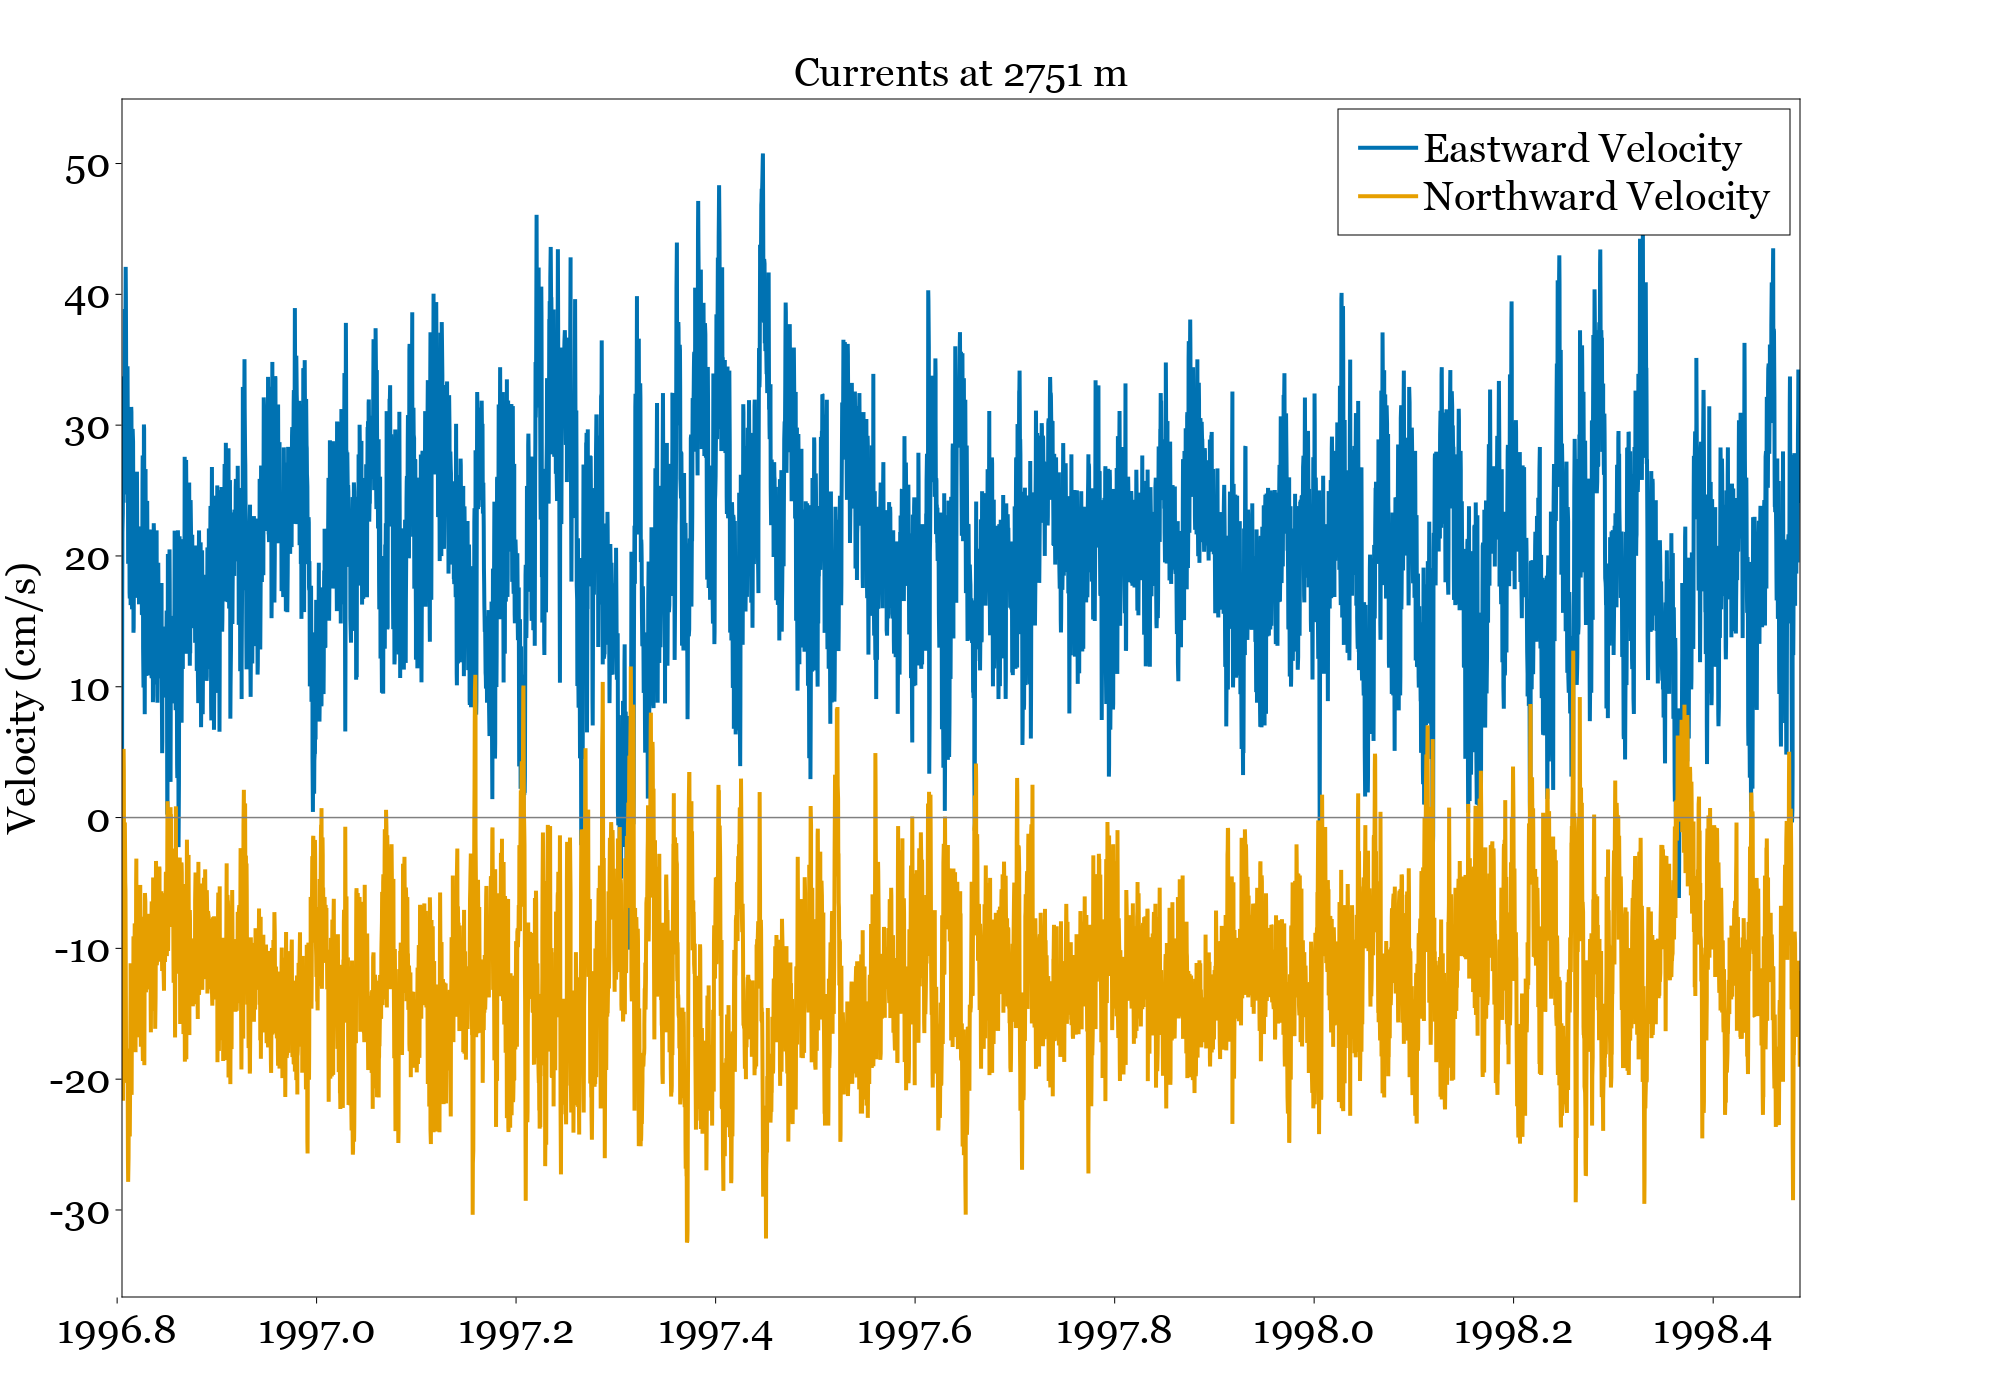

In [5]:
#create a theme for this and similar line plots
lineplottheme = Theme(
    resolution = (2000, 1400),
    figure_padding = (0,200,50,50), #to improve appearance for display in Jupyter
    backgroundcolor = :transparent, #for output to RISE
    fonts = (regular = "Georgia",); fontsize = 40, 
    Axis = (xgridvisible = false, ygridvisible = false, titlefont = "Georgia", 
        yticks = (-30:10:60), xticks = (1996:.2:1998.4), xautolimitmargin = (0, 0)), 
    Lines = (cycle = Cycle(:color), linewidth = 4), 
    Legend = (merge = true, linepoints = [Point2f(-2, 0.5), Point2f(1, 0.5)], 
              padding = (60.0f0, 20.0f0, 16.0f0, 16.0f0)), #tweaking the legend
)

set_theme!(lineplottheme)
f = Figure(); ax = Axis(f[1, 1])
lines!(yearfrac.(tim), real.(cv[:, end]), label = "Eastward Velocity")
lines!(yearfrac.(tim), imag.(cv[:, end]), label = "Northward Velocity")
ax.title = "Currents at " * string(Integer(depths[end])) * " m"
ax.ylabel = "Velocity (cm/s)"
hlines!(0;color = :grey); axislegend(ax)
display(f);

Here a mean value is readily apparent in both the eastward and northward components.  In addition, we see a lot of small-scale variability, possibly with a greater amplitude in the eastward component.  Hints of multiple timescales of variability are present, with a fine noise-like variability superposed on somewhat longer timescales.

It is a little difficult to make sense of this plot, however, because it is not rotated into the most useful coordinate system.  Let's figure out a sensible rotation angle. 

# Choosing a Coordinate Rotation

To do this, we will look at the progressive vector diagram.  For a current measurement at a point, the progressive vector diagram is defined as a plot of its time integral.  In other words, the progressive vector diagram shows the displacement that would occur if a particle were advected with the given currents.


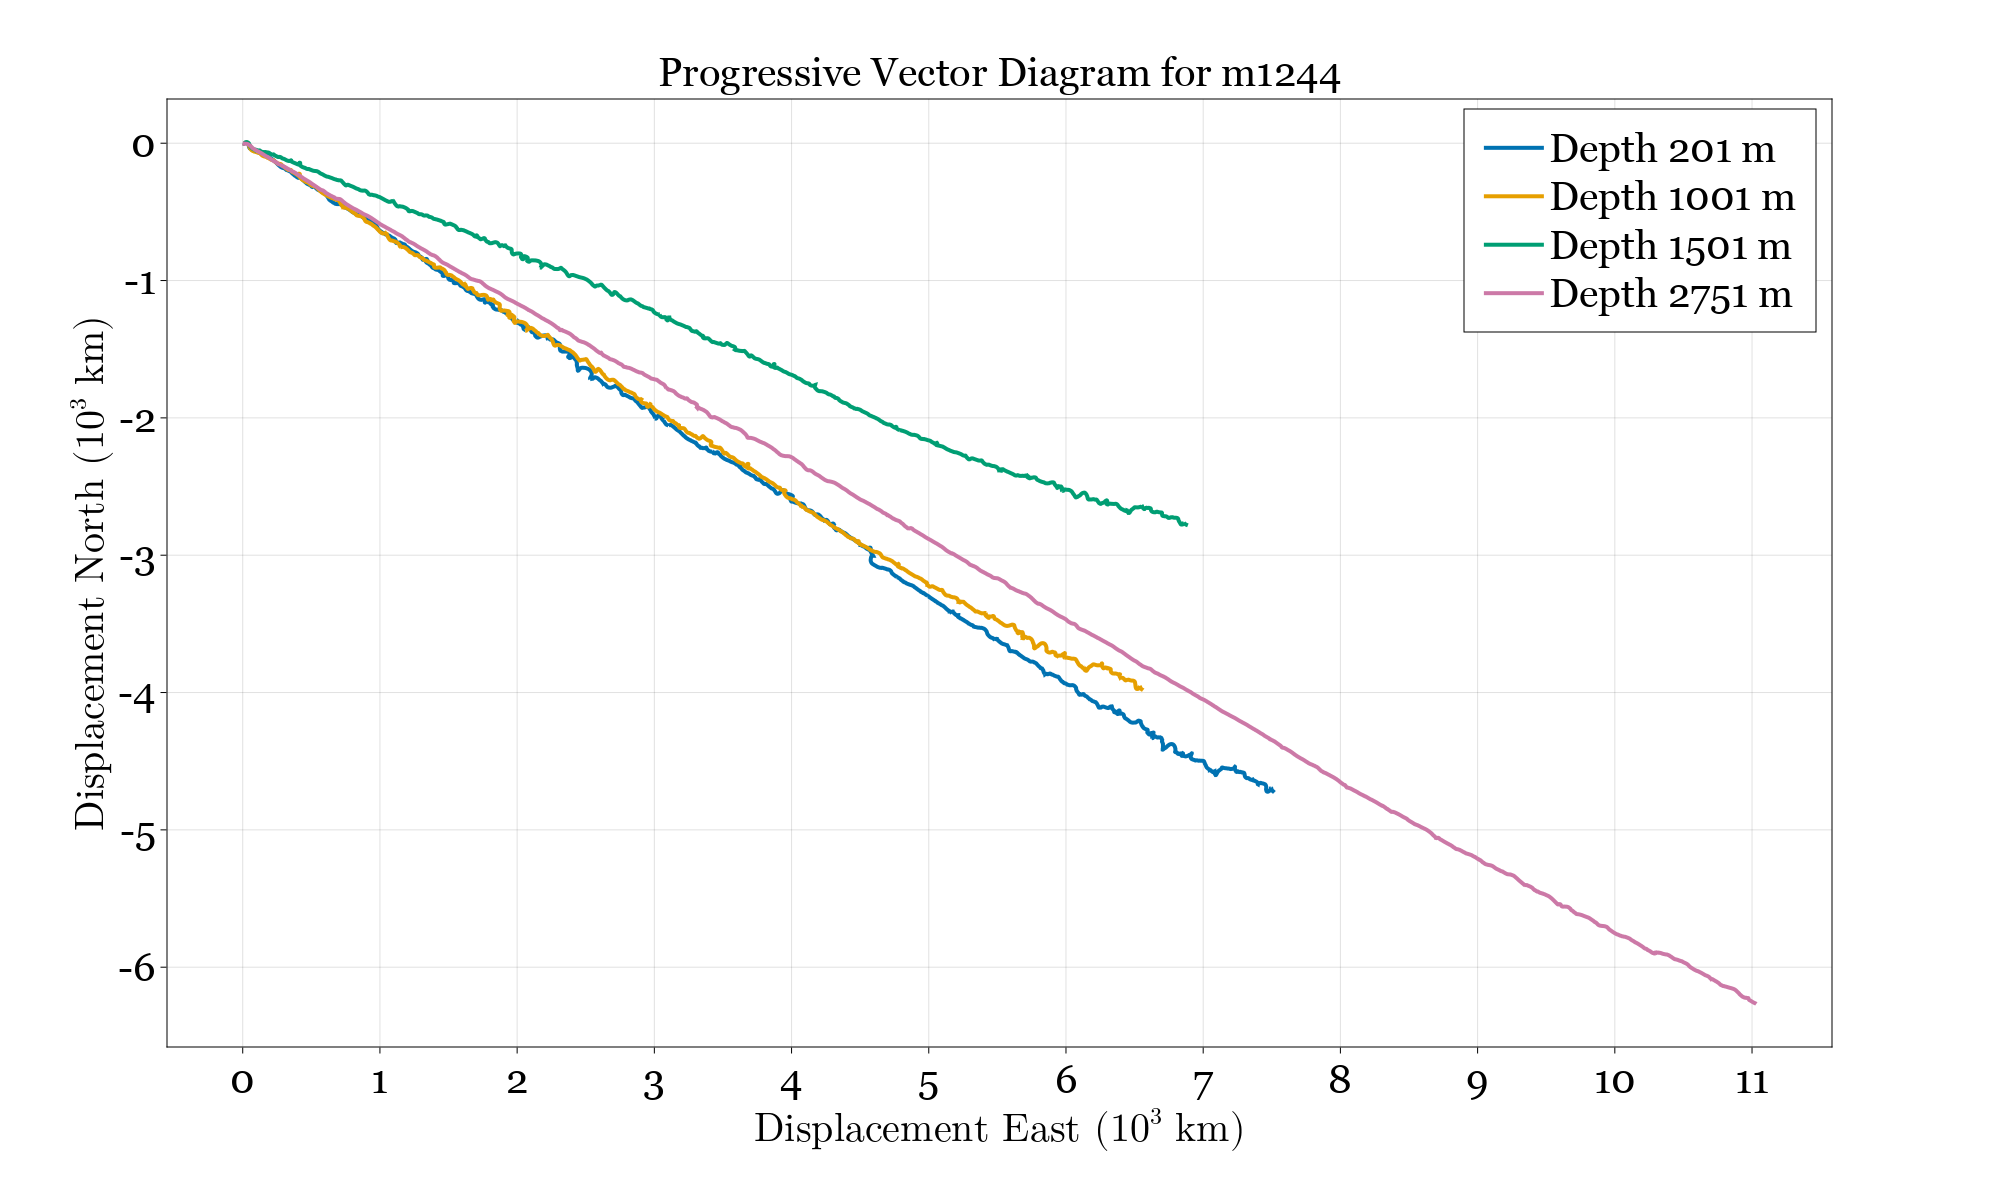

In [6]:
#create a theme for progressive vector plots
provectheme = Theme(
    resolution = (2000, 1200),
    figure_padding = (0,100,50,50), #to improve appearance for display in Jupyter
    backgroundcolor = :transparent, #for output to RISE
    fonts = (regular = "Georgia",); fontsize = 40, 
    Axis = (titlefont = "Georgia", xticks = (-10:1:18), yticks = (-10:1:10), 
        xlabel = L"Displacement East ($10^3$ km)", 
        ylabel = L"Displacement North ($10^3$ km)",
        aspect = DataAspect()), #to correctly set aspect ratio in Julia
    Lines = (cycle = Cycle(:color), linewidth = 4), 
    Legend = (merge = true, linepoints = [Point2f(-2, 0.5), Point2f(1, 0.5)], 
        padding = (60.0f0, 20.0f0, 16.0f0, 16.0f0)) #tweaking the legend
)

dt = Dates.value.(tim[2] - tim[1]) ./ 1000     #sampling interval in seconds
cx = cumsum(cv;dims = 1) .* dt ./ 100 ./ 1e6   #complex displacement x+iy in megameters

set_theme!(provectheme)
f = Figure(); ax = Axis(f[1, 1])
[lines!(real.(cx[:, n]), imag.(cx[:, n]), 
        label = "Depth " * string(Integer(depths[n])) * " m") for n in 1:size(cv, 2)]
ax.title = "Progressive Vector Diagram for m1244"
axislegend(ax)
display(f);

We see a strong mean flow at all depths directed to the east-southeast.  This matches what we saw above with the line plot, where the positive mean of the eastward currents is roughly twice as large as the negative mean of the southward currents. 

Please note, it is important to set the aspect ratio correctly in such plots.  Otherwise, the direction of the mean flow will be misrepresented.

# Rotating by the Mean Flow Direction

It's natural to rotate our current meter data so that the east-southeastward direction of the mean flow corresponds to the first velocity component, and the direction normal to that to the second velocity component.  In other words, we will rotate our $(u, v)$ data to become $(\tilde u, \tilde v)$ with $\tilde u$ corresponding to the ‘downstream’ direction and $\tilde v$ corresponds to the ‘cross-stream’ direction. We will take a little time to do this so we understand how rotations work.   

Firstly we find the direction of the mean flow at the deepest current meter, where the flow is strongest.

In [7]:
angle(mean(cv[:, end])) .* 360 ./ 2 ./ pi  #angle in radians converted to degrees

-29.60280682701634

So the angle is about 30 degrees clockwise from due east.  That looks about right!

Rotation of a complex-valued number $z = u+iv$ are straightforward. To rotate $z = |z|e^{i\varphi}$ through some angle $\phi$, we simply multiply by $e^{i\phi}$.  This leads to a new version of $z$ , denoted $\tilde z  = \tilde u+i\tilde v = |z|e^{i(\varphi+\phi)}$. 

In this case, we want to choose the rotation angle $\phi$ as the *negative* of the angle of the mean flow.  Let's look at the mean real and imaginary components of the velocity before and after this rotation.

In [8]:
phi = -angle(mean(cv[:, 4]))
mean(cv[:, 4] .* exp.(im .* phi)) 

23.906275152459898 - 4.0101177326848686e-16im

This shows that after the rotation, the mean of the cross-stream velocity (the imaginary part) is essentially zero, as expected.  Now let's re-plot the progressive vector diagram. 

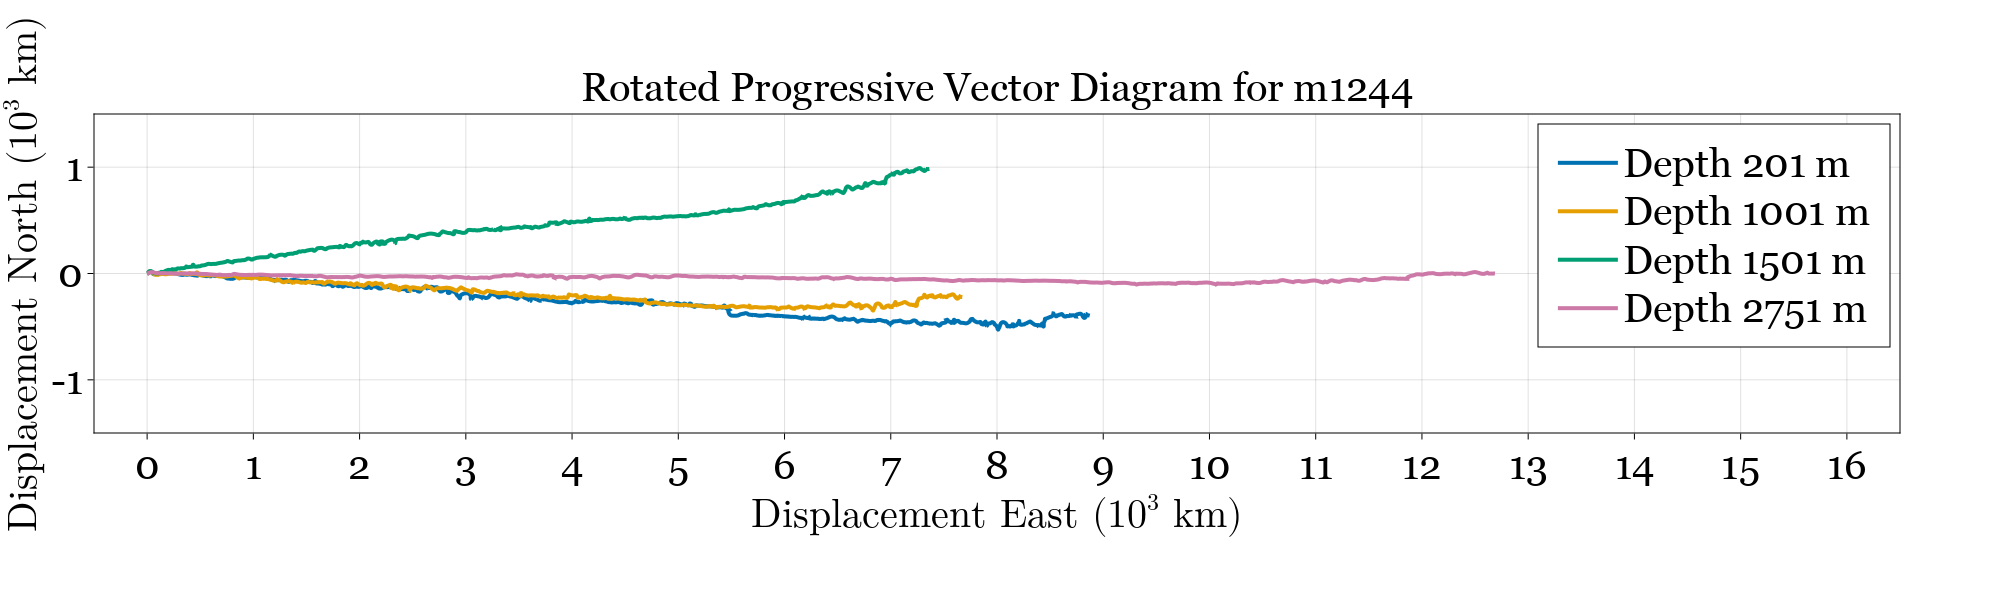

In [9]:
f = Figure(;resolution = (2000, 600))
ax = Axis(f[1, 1], limits = (-.5, 16.5, -1.5, 1.5))
[lines!(real.(cx[:, n] .* exp.(im * phi)), imag.(cx[:, n] .* exp.(im * phi)), 
        label = "Depth " * string(Integer(depths[n])) * " m") for n in 1:size(cv, 2)]
ax.title = "Rotated Progressive Vector Diagram for m1244"
axislegend(ax)
display(f);

At first glance, this plot appears rather boring.  But actually, boring can be a good sign because it means we've found a way to look at our dataset in such a way that it simplifies!  

Let's return to the line plot we made earlier, but now make it for the rotated velocity data.

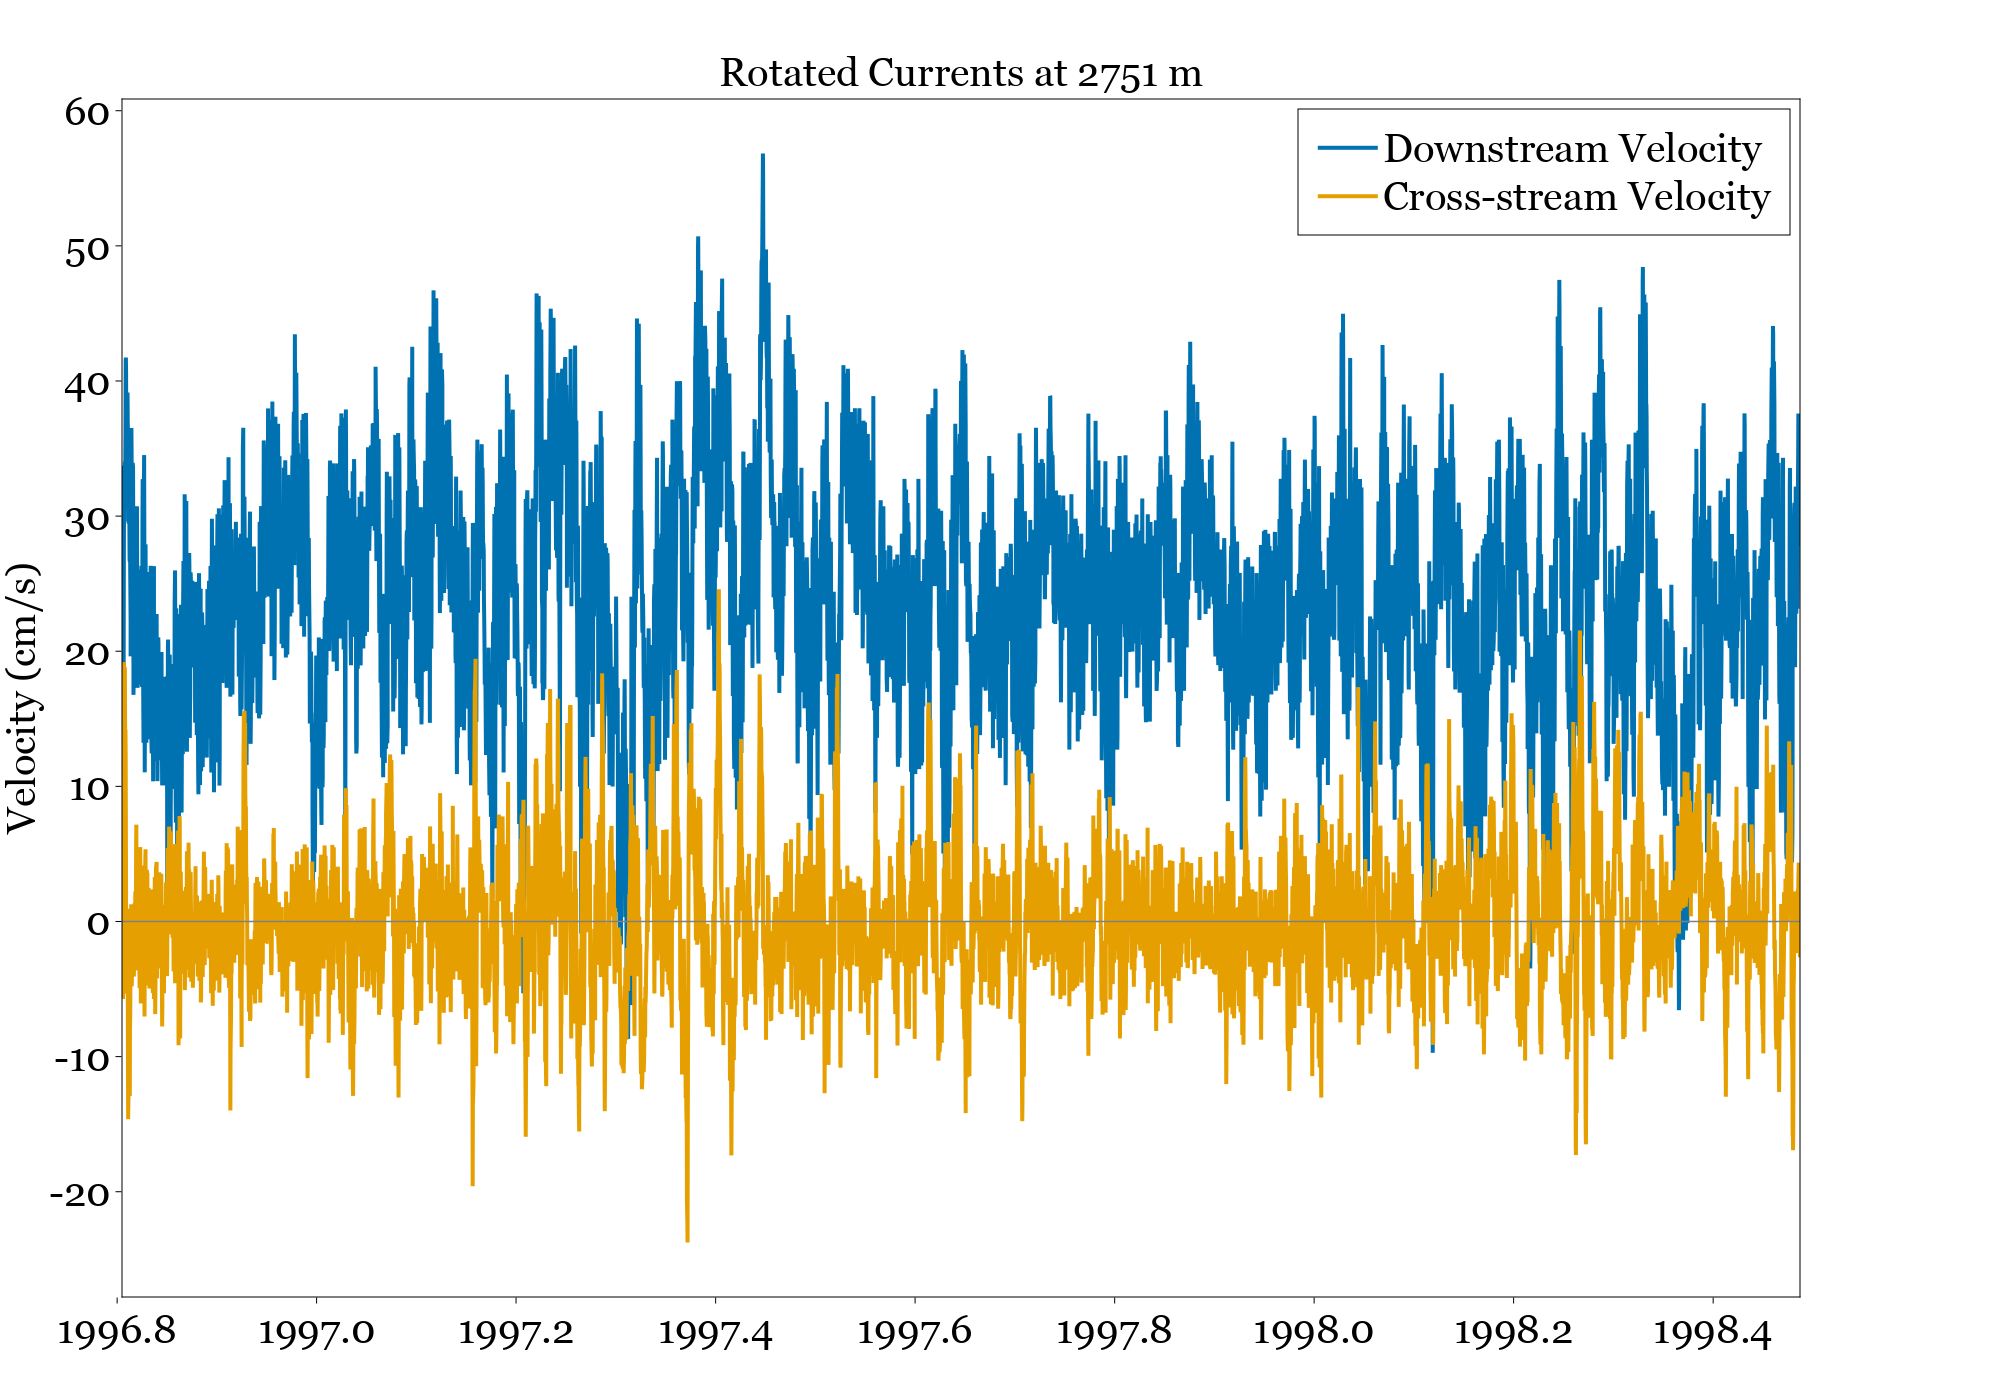

In [10]:
rcv = cv .* exp.(im .* phi)  #Define a rotated version of the velocity 

set_theme!(lineplottheme)
f = Figure(); ax = Axis(f[1, 1])
lines!(yearfrac.(tim), real.(rcv[:, end]), label = "Downstream Velocity")
lines!(yearfrac.(tim), imag.(rcv[:, end]), label = "Cross-stream Velocity")
ax.title = "Rotated Currents at " * string(Integer(depths[end])) * " m"
ax.ylabel = "Velocity (cm/s)"
hlines!(0;color = :grey); axislegend(ax)
display(f);

The downstream and cross-stream components are seen to be distinctly different. The cross-stream flow oscillates about a mean of zero, which is by construction, and also presents higher-frequency variability than does the downstream flow.  Or, perhaps more accuately, it appears that the cross-stream flow is *lacking* an intermediate-timescale component that is present in the downstream flow. 

Let's take a closer look at the timescales present in this dataset with a simple lowpass filter. We'll use a 24-point filter, which corresponds to a 2-day running mean since the sampling interval is 2 hours.  For simplicity, we'll use a Hanning window.

In Julia, the easiest way to filter is currently using imfilter from [ImageFiltering.jl](https://github.com/JuliaImages/ImageFiltering.jl). One detail worth pointing out is that this applies a correlation operator rather than a convolution operator, as described in the [documentation](https://juliaimages.org/ImageFiltering.jl/stable/function_reference/#ImageFiltering.imfilter).  The difference between these is discussed in the course notes. For symmetric filters such as the Hanning window convolution and correlation are the same, but for asymmetric filters we would need to time-reverse the filter in order to obtain a convolution.  

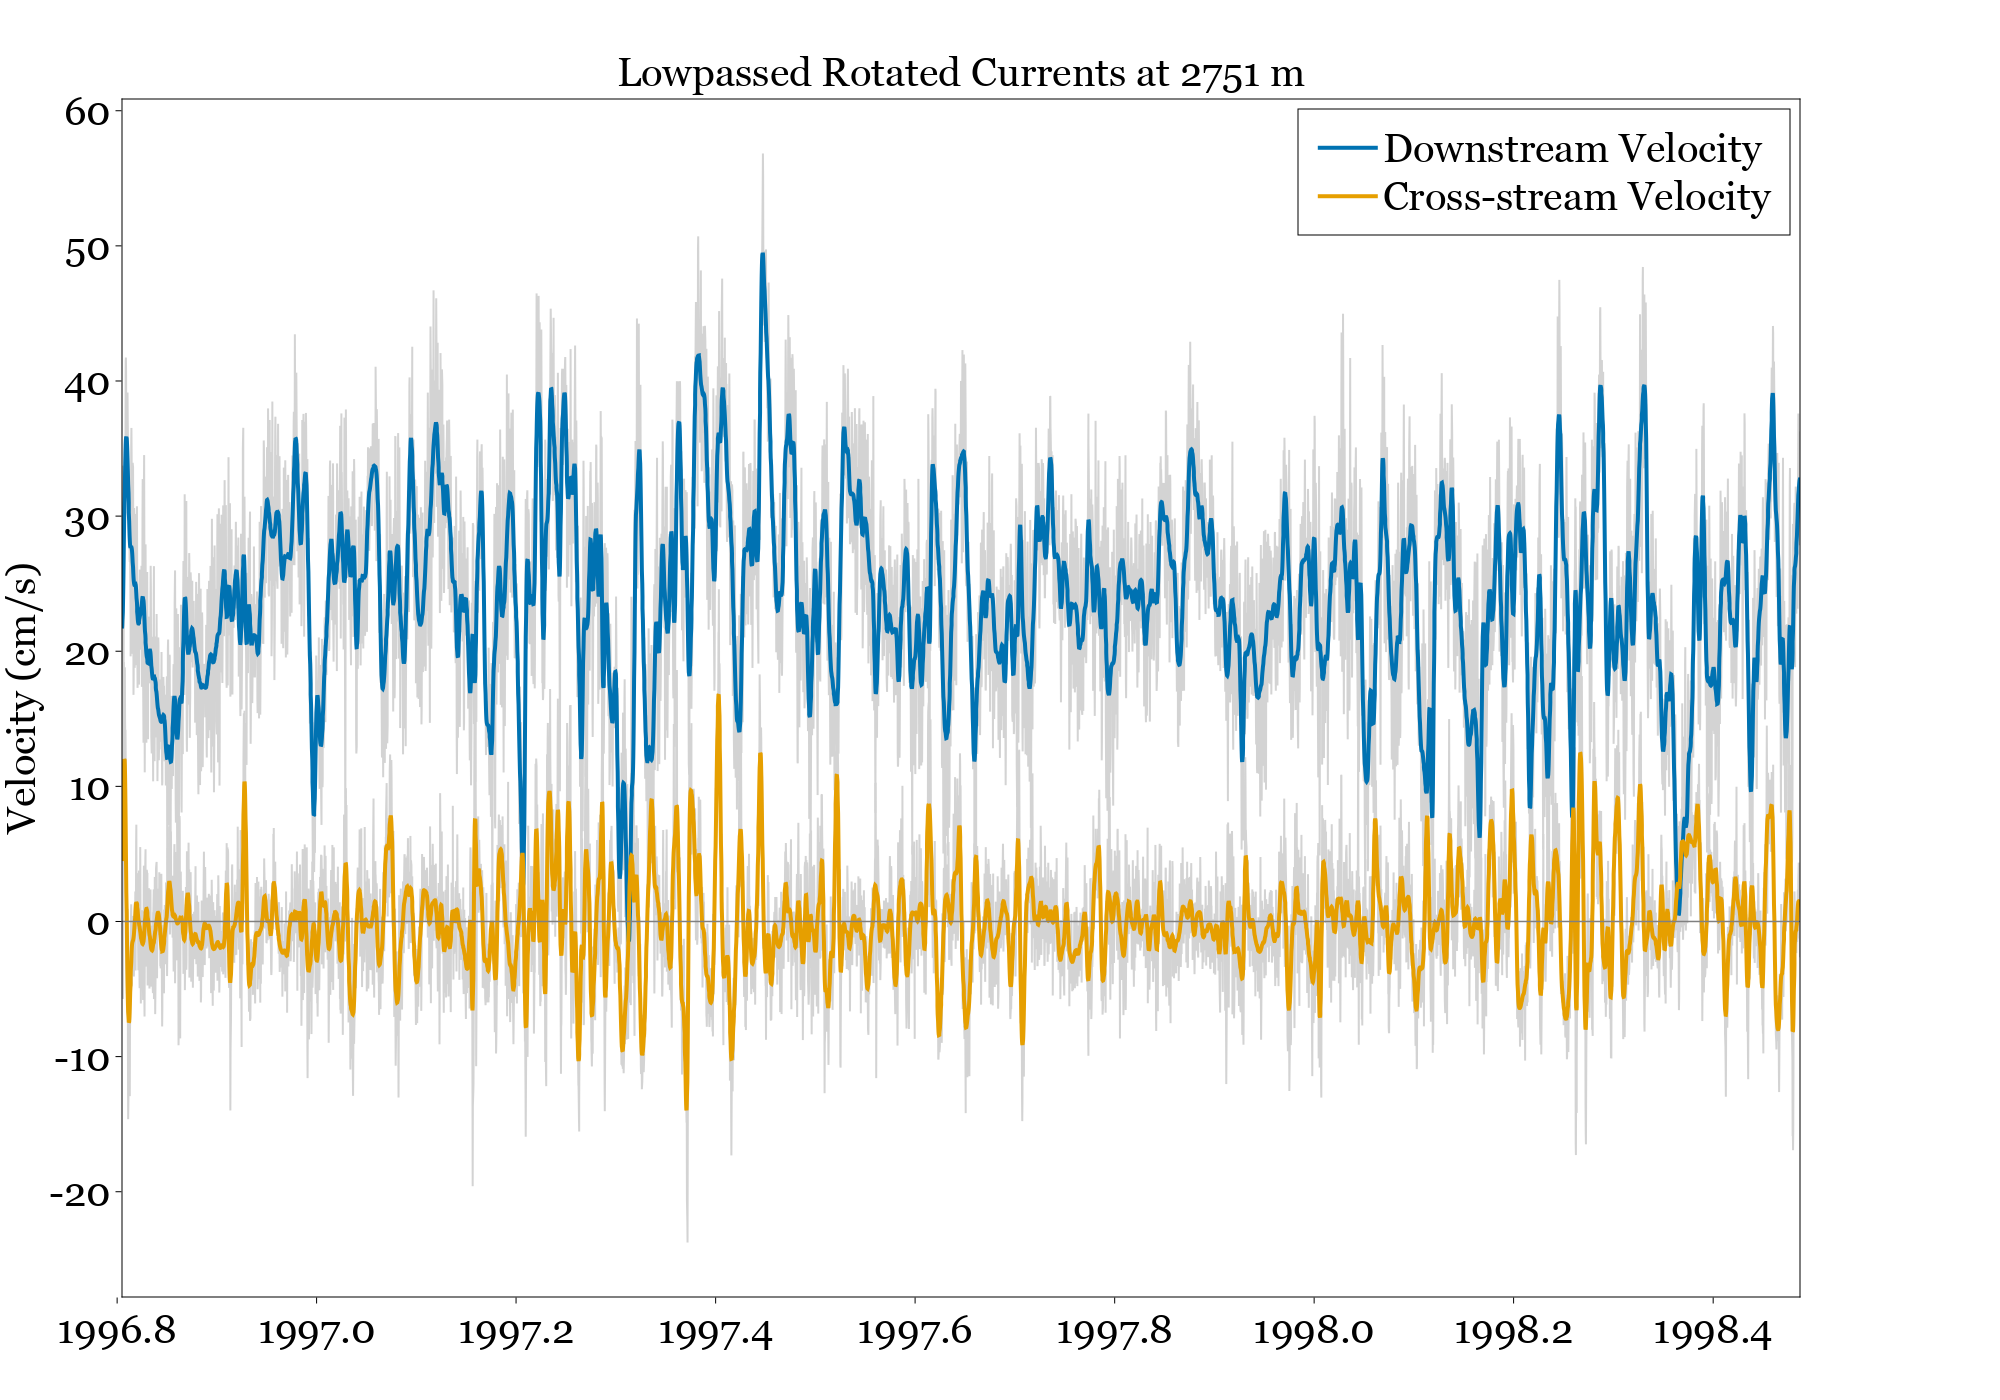

In [11]:
#create filtered version of the time series
frcv = imfilter(rcv[:,end], unitsum(hanning(24)), "reflect") #unitsum is defined at the top

f = Figure(); ax = Axis(f[1, 1])
lines!(yearfrac.(tim), real.(rcv[:, end]), color = :lightgrey, linewidth = 2)
lines!(yearfrac.(tim), imag.(rcv[:, end]), color = :lightgrey, linewidth = 2)
lines!(yearfrac.(tim), real.(frcv[:, end]), label = "Downstream Velocity")
lines!(yearfrac.(tim), imag.(frcv[:, end]), label = "Cross-stream Velocity")
ax.title = "Lowpassed Rotated Currents at " * string(Integer(depths[end])) * " m"
ax.ylabel = "Velocity (cm/s)"
hlines!(0;color = :grey); axislegend(ax)
display(f);

Here we can see clearly that the downstream flow presents an intermediate-timescale variability that is not present in the cross-stream flow.  

Our rotation, designed just based on the *mean* , has thus also revealed distinctions in *variability*.  The variability of the flow is now seen as being *anisotropic* , that is, lacking the property of being the same in all directions.  This was not visible before the rotation because the downsteam and cross-stream components were mixed.

In general, finding ways to "rotate" a dataset, perhaps in an abstract way, in such a way that variability presents anisotropic structure is a quite simple yet powerful approach we can use to unlock its information content.

Here, the different timescales between the two components is not what one would expect if the variability were entirely due to the advection of eddies past the mooring; the timescales in that case would be the same.  So this plot informs the physical hypotheses we would frame regarding the nature of the variability. 

# Two-Dimensional Histograms

Next we will summarize the statistics of the velocity through looking at its properties on the $u,v$ plane. First, we'll make a simple line plot of $\tilde u$ versus $\tilde v$---a type of plot known as a *hodograph*---for the rotated versions of the currents we created earlier.  We'll work with the lowpassed version of the time series for the moment.   

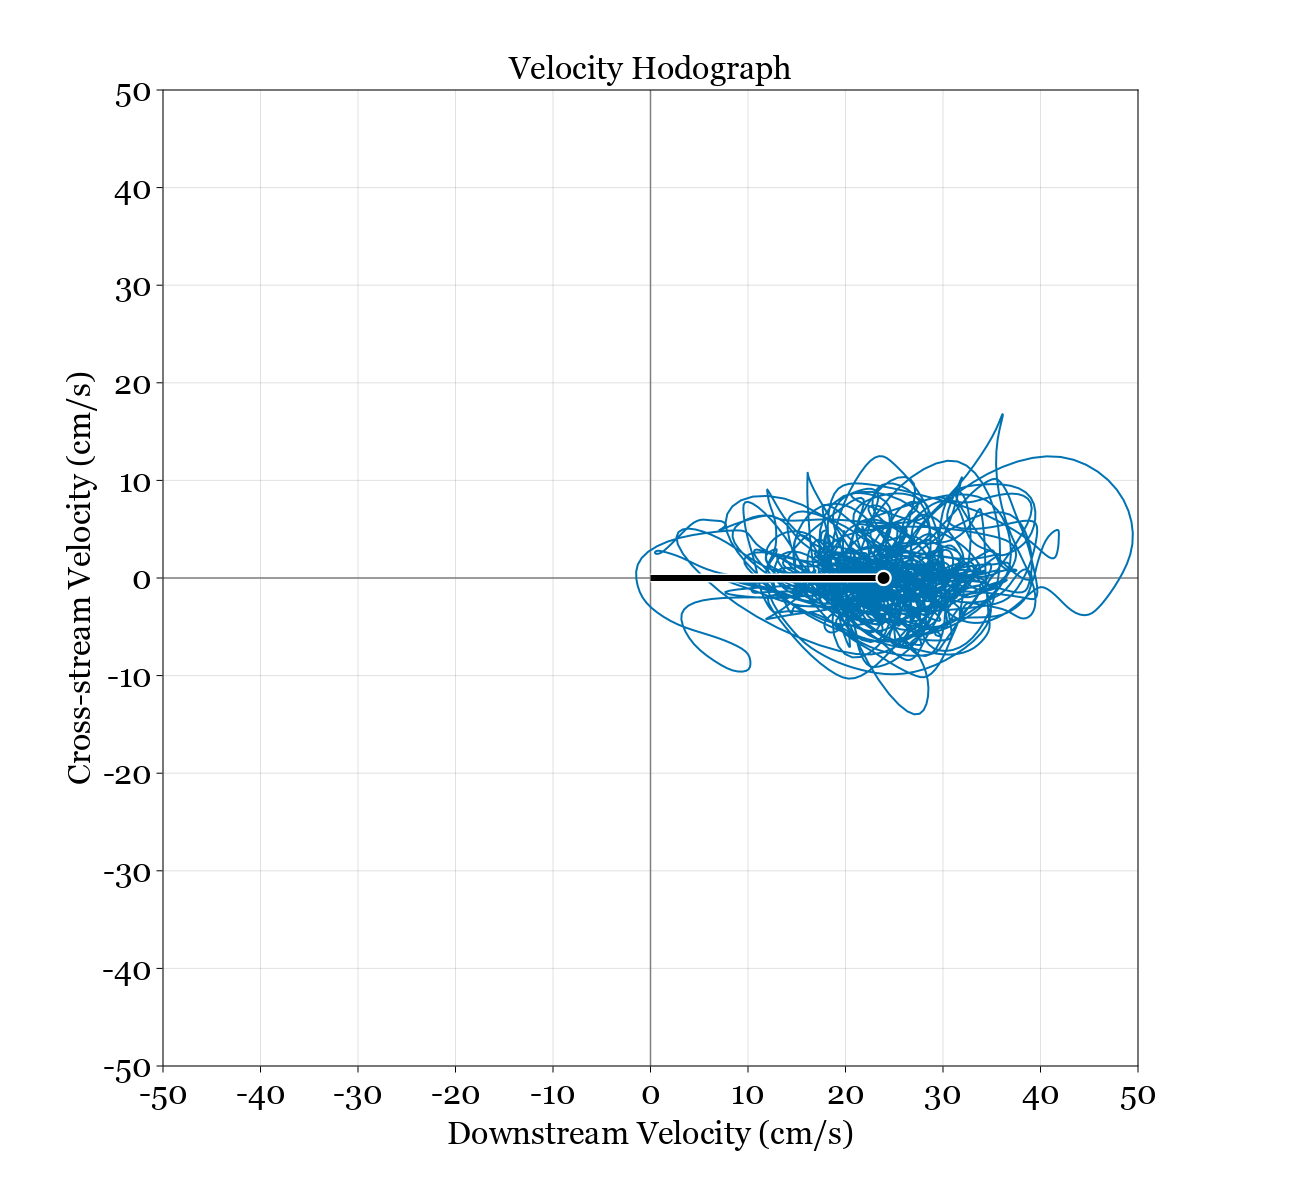

In [12]:
#create a theme for plots the u/v plane
uvplanetheme = Theme(
    resolution = (1300, 1200),
    figure_padding = (0,100,50,50), #to improve appearance for display in Jupyter
    backgroundcolor = :transparent, #for output to RISE
    fonts = (regular = "Georgia",); fontsize = 32, 
    Axis = (titlefont = "Georgia", xticks = (-50:10:50), yticks = (-50:10:50), 
        xlabel = "Downstream Velocity (cm/s)", ylabel = "Cross-stream Velocity (cm/s)", 
        limits = (-50, 50, -50, 50), 
        aspect = DataAspect()), #to correctly set aspect ratio in Julia
    Lines = (cycle = Cycle(:color), linewidth = 4), 
    Heatmap = (colormap = Reverse(:Spectral_11), lowclip = :transparent, nan_color = :transparent), 
    Colorbar = (height = Relative(0.9),),
    Legend = (merge = true, linepoints = [Point2f(-2, 0.5), Point2f(1, 0.5)], 
              padding = (60.0f0, 20.0f0, 16.0f0, 16.0f0)) #tweaking the legend
)

set_theme!(uvplanetheme)
f = Figure(); ax = Axis(f[1, 1])
vlines!(0, color = :grey); hlines!(0, color = :grey)
lines!(real(frcv[:, end]), imag(frcv[:, end]), linewidth = 2)
plot_vector!(mean(rcv[:,end])) 
ax.title = "Velocity Hodograph"
display(f);

The mean flow is plotted for reference.  Note that the time integral of this plot is the progressive vector diagram. 

At first glance, this plot is not very informative.  It basically tells us that there is varability about the mean, with greater variability along the downstream axis then the cross-stream axis, which we already knew.  But we can use statistics to nicely summarize what we are seeing.

To do this we will look at two-dimensional distributions of the velocity. Firstly, we plot the two-dimensional histogram at the deepest depth. 

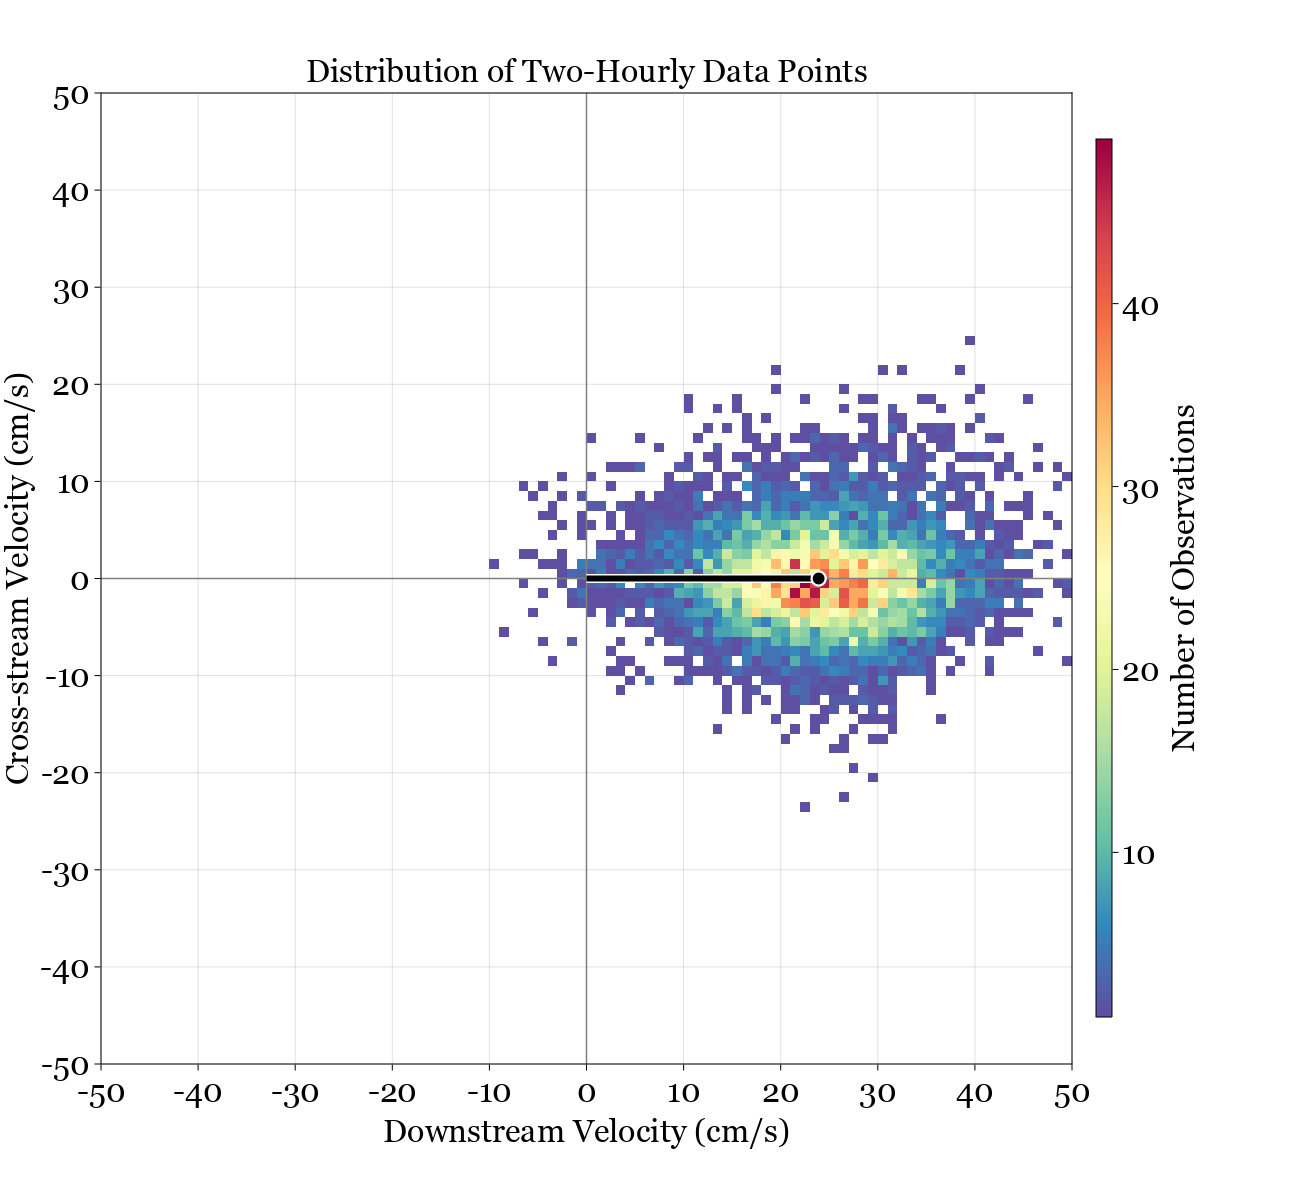

In [13]:
xedges, yedges = (-50:50), (-50:50)
set_theme!(uvplanetheme)
f = Figure();ax = Axis(f[1, 1])
mat = histcounts(real.(rcv[:, end]), imag.(rcv[:, end]), xedges, yedges)
#note that makie heatmap is expecting z with x along rows, so we must transpose
hm = heatmap!(mid(xedges), mid(yedges), mat', colorrange = (1, maximum(mat)))
vlines!(0, color = :grey);hlines!(0, color = :grey)
plot_vector!(mean(rcv[:,end])) 
Colorbar(f[1, 2], hm, label = "Number of Observations")
ax.title = "Distribution of Two-Hourly Data Points"
display(f);

This plots shows the number of observations within each bin, which we have specified to be $1\times 1$ cm/s bins ranging from -50 to 50 cm/s in both axes.  The white bins are never observed. 

The histogram of the velocity has a roughly elliptical shape, elongated along the x-axis.  We now have a picture of a "cloud" of possibilities, with, generally speaking, bins closer to the location of the mean flow occurring more frequently. 

Note this plot contains more information than was visible in the line plot, because while the line plot also showed us the *shape* of the distribution, it did not provide us with information as to the relative frequency of occurrence of velocity values. 

When making 2D statistics plots such as these, make sure to pay attention to bin size. Too large of a bin size leads to a blocky-looking plot, while too find of a bin size changes the cloud into a mist. In either case, we can't see much structure.  Thus, you'll want to play around with your bin sizes.  For this dataset, 1 cm/s bins seems to be a good choice.

Finally, one useful trick is to plot not the number of observations per bin, but rather the *logarithm* of the number of observations, like so:

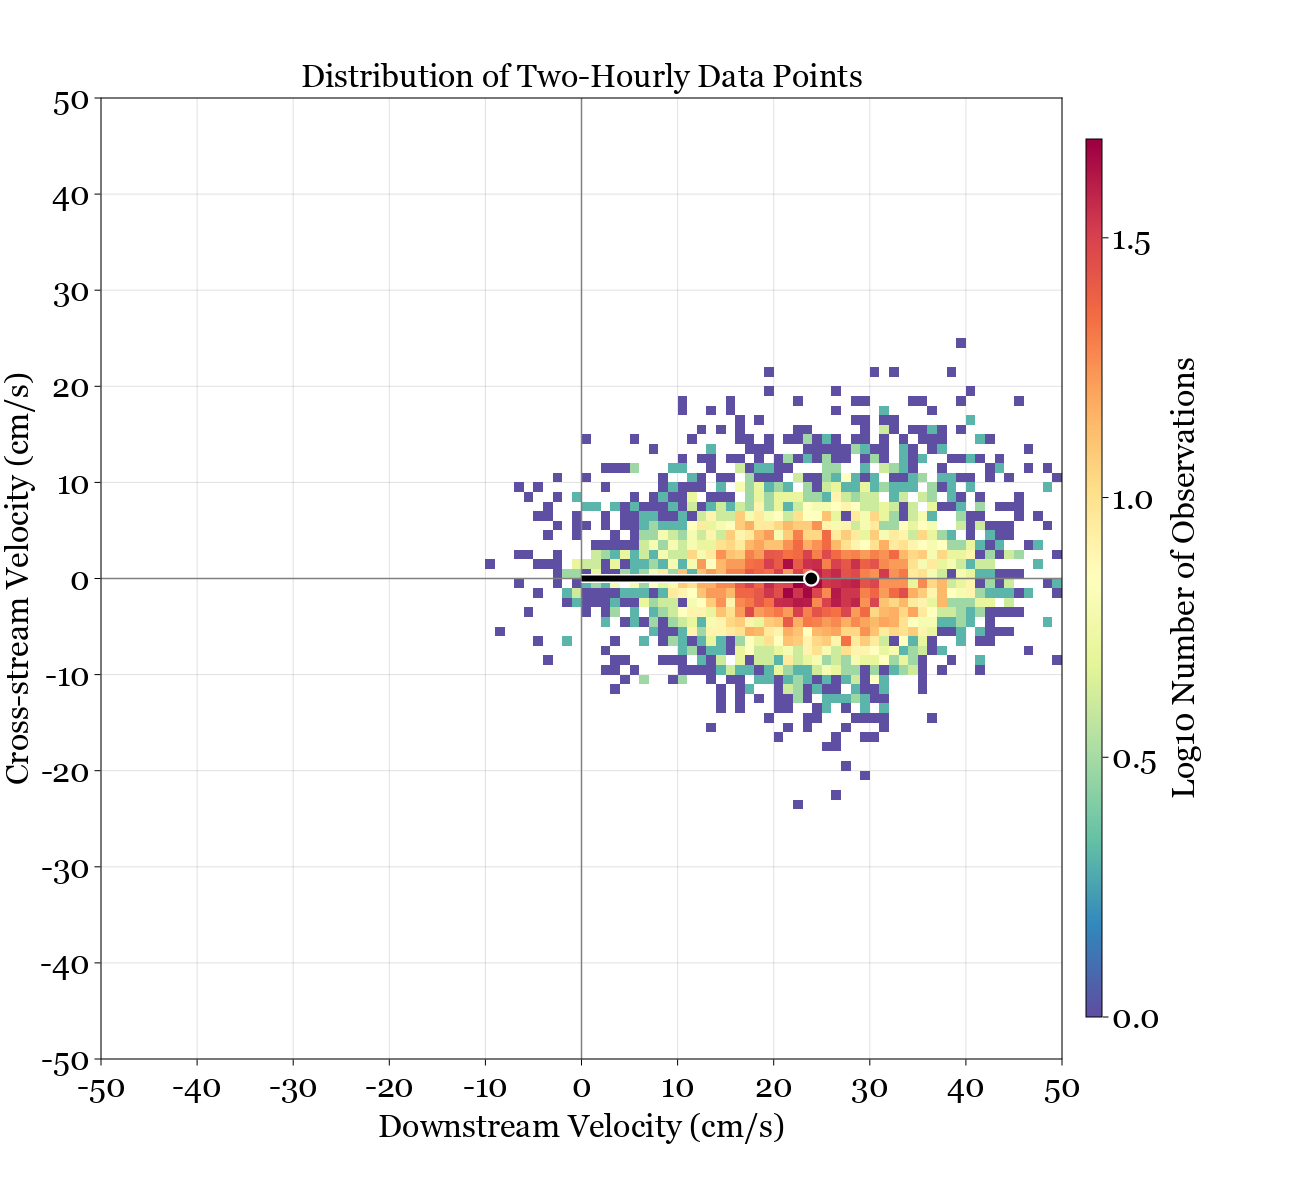

In [14]:
#same plot as above but with a logarithmic color axis
f = Figure();ax = Axis(f[1, 1])
mat = histcounts(real.(rcv[:, end]), imag.(rcv[:, end]), xedges, yedges)
hm = heatmap!(mid(xedges), mid(yedges), log10.(mat)', colorrange = (0, maximum(log10.(mat))))
vlines!(0, color = :grey);hlines!(0, color = :grey)
plot_vector!(mean(rcv[:,end])) 
Colorbar(f[1, 2], hm, label = "Log10 Number of Observations")
ax.title = "Distribution of Two-Hourly Data Points"
display(f);

This has the effect of allowing regions with radically different densities to be visualized together.  The logarithm "flattens" the plot, since for exmaple, log10(100) = 2, log10(10) = 1, and log10(1) = 0.  

In this plot, the structure on the flanks of the distribution, where very few data points occur, now appears more visible.  In general, you'll want to play around to see if linear or logarithmic histograms are more informative. 

# The Variance Ellipse

Finally we are ready to look at a quantity called the variance ellipse.  We will study this more in the lectures; here we will just get a feeling for how it works.

First we form the terms in the covariance matrix for the rotated velocities at the deepest depth.  Then, we diagonalize the covariance matrix with an eigenvalue decomposition.  

In [15]:
#covmat, covdiag, and ellipse are all defined at the top of this lab
Σ = covmat(real(rcv[:, end]), imag(rcv[:, end]))
a, b, θ = covdiag(Σ)
z = ellipse.(a, b, θ, (-1:0.01:1) * pi);

Because the velocity consists of a *pair* of variables $\tilde u$ and $\tilde v$, its second-order statistics are not just the variances of $\tilde u$ and $\tilde v$ separately. One must also take into account their covariance.  

The diagonalization of the covariance matrix expresses this same information in a different way. It will be shown in class that the eigenvalues of the covariance matrix are the squares of the semi-major and semi-minor axes of an ellipse, respectively, while the eigenvector matrix is a rotation matrix by $\theta$, the orientation of the major axis of the ellipse with respect to the x-axis. 

This quantity is called the variance ellipse.  Just as the variance is the fundamental second-order statistical quantity for a single or univariate time series, such as $u$, the variance ellipse is the fundamental second-order statistical quantity for a pair of time series $(u, v)$. 

Now we return to the 2D histogram presented earlier, adding a plot of the variance ellipse.

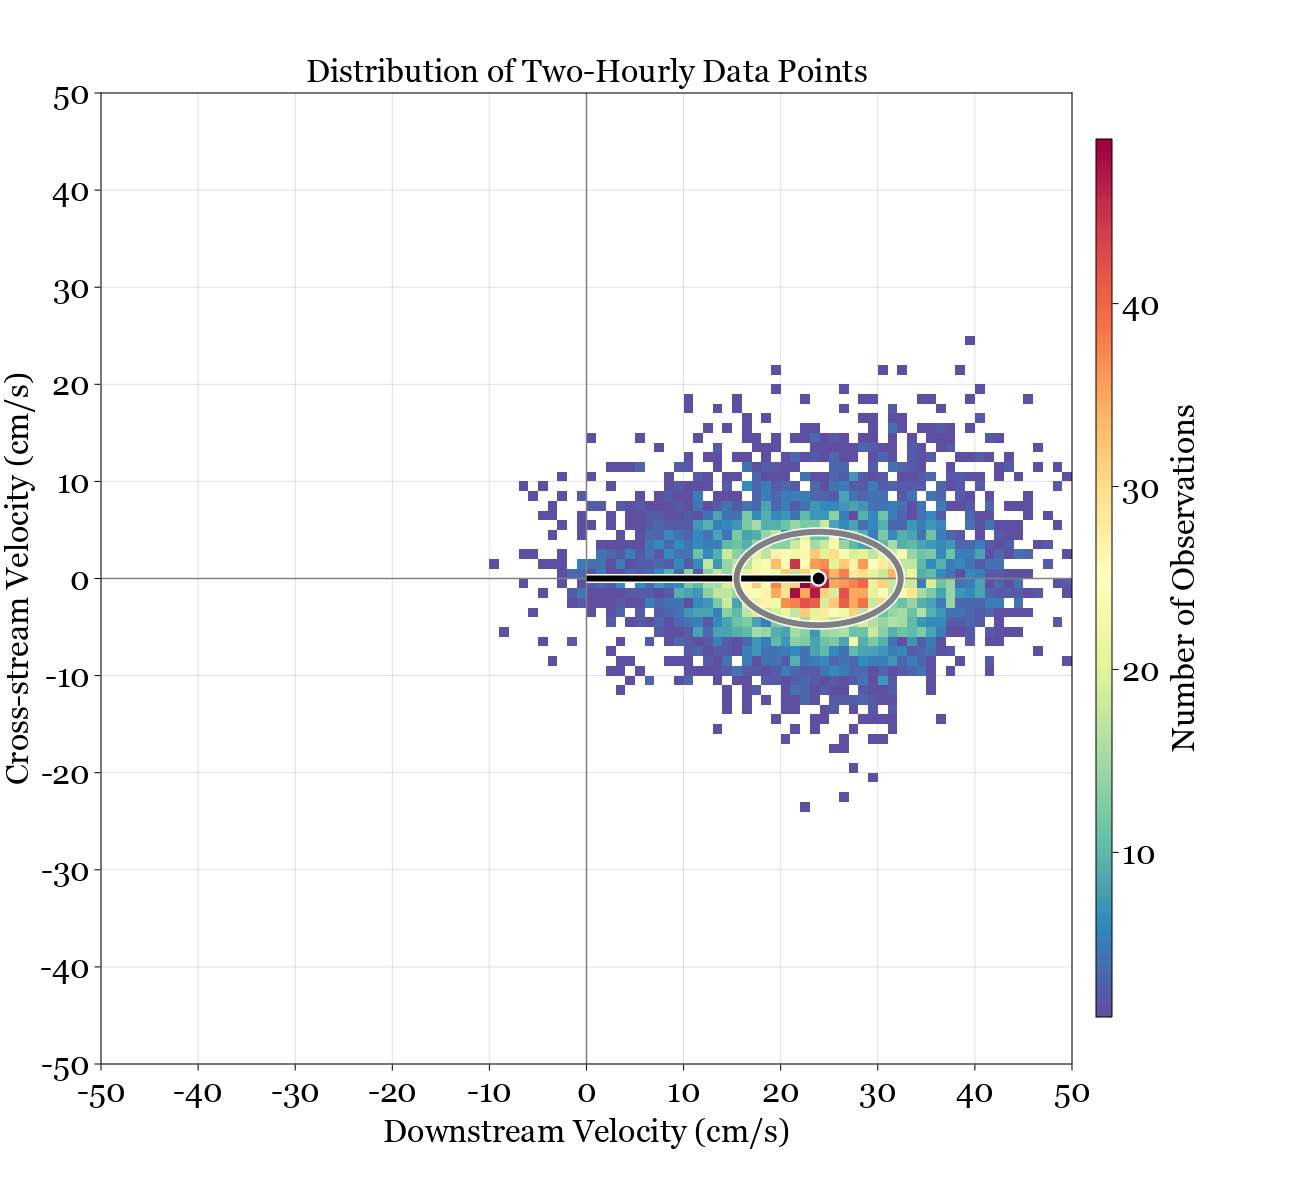

In [16]:
#2d histogram with linear colorscale again, but this time adding an ellipse
set_theme!(uvplanetheme)
f = Figure();ax = Axis(f[1, 1])
mat = histcounts(real.(rcv[:, end]), imag.(rcv[:, end]), xedges, yedges)
hm = heatmap!(mid(xedges), mid(yedges), mat', colorrange = (1, maximum(mat)))
vlines!(0, color = :grey);hlines!(0, color = :grey)
plot_vector!(mean(rcv[:,end])) 
plot_ellipse!(z; origin = mean(rcv[:, end]))
Colorbar(f[1, 2], hm, label = "Number of Observations")
ax.title = "Distribution of Two-Hourly Data Points"
display(f);

You can see that the basic shape of the velocity distribution is indeed capture by the variance ellipse.  Variance ellipses are a powerful tool for describing the basic features of velocity fluctuations, as we shall see.

Next we will make the nicer version of the 2D histogram for all four depths, by just looping over the code blocks we have already used.

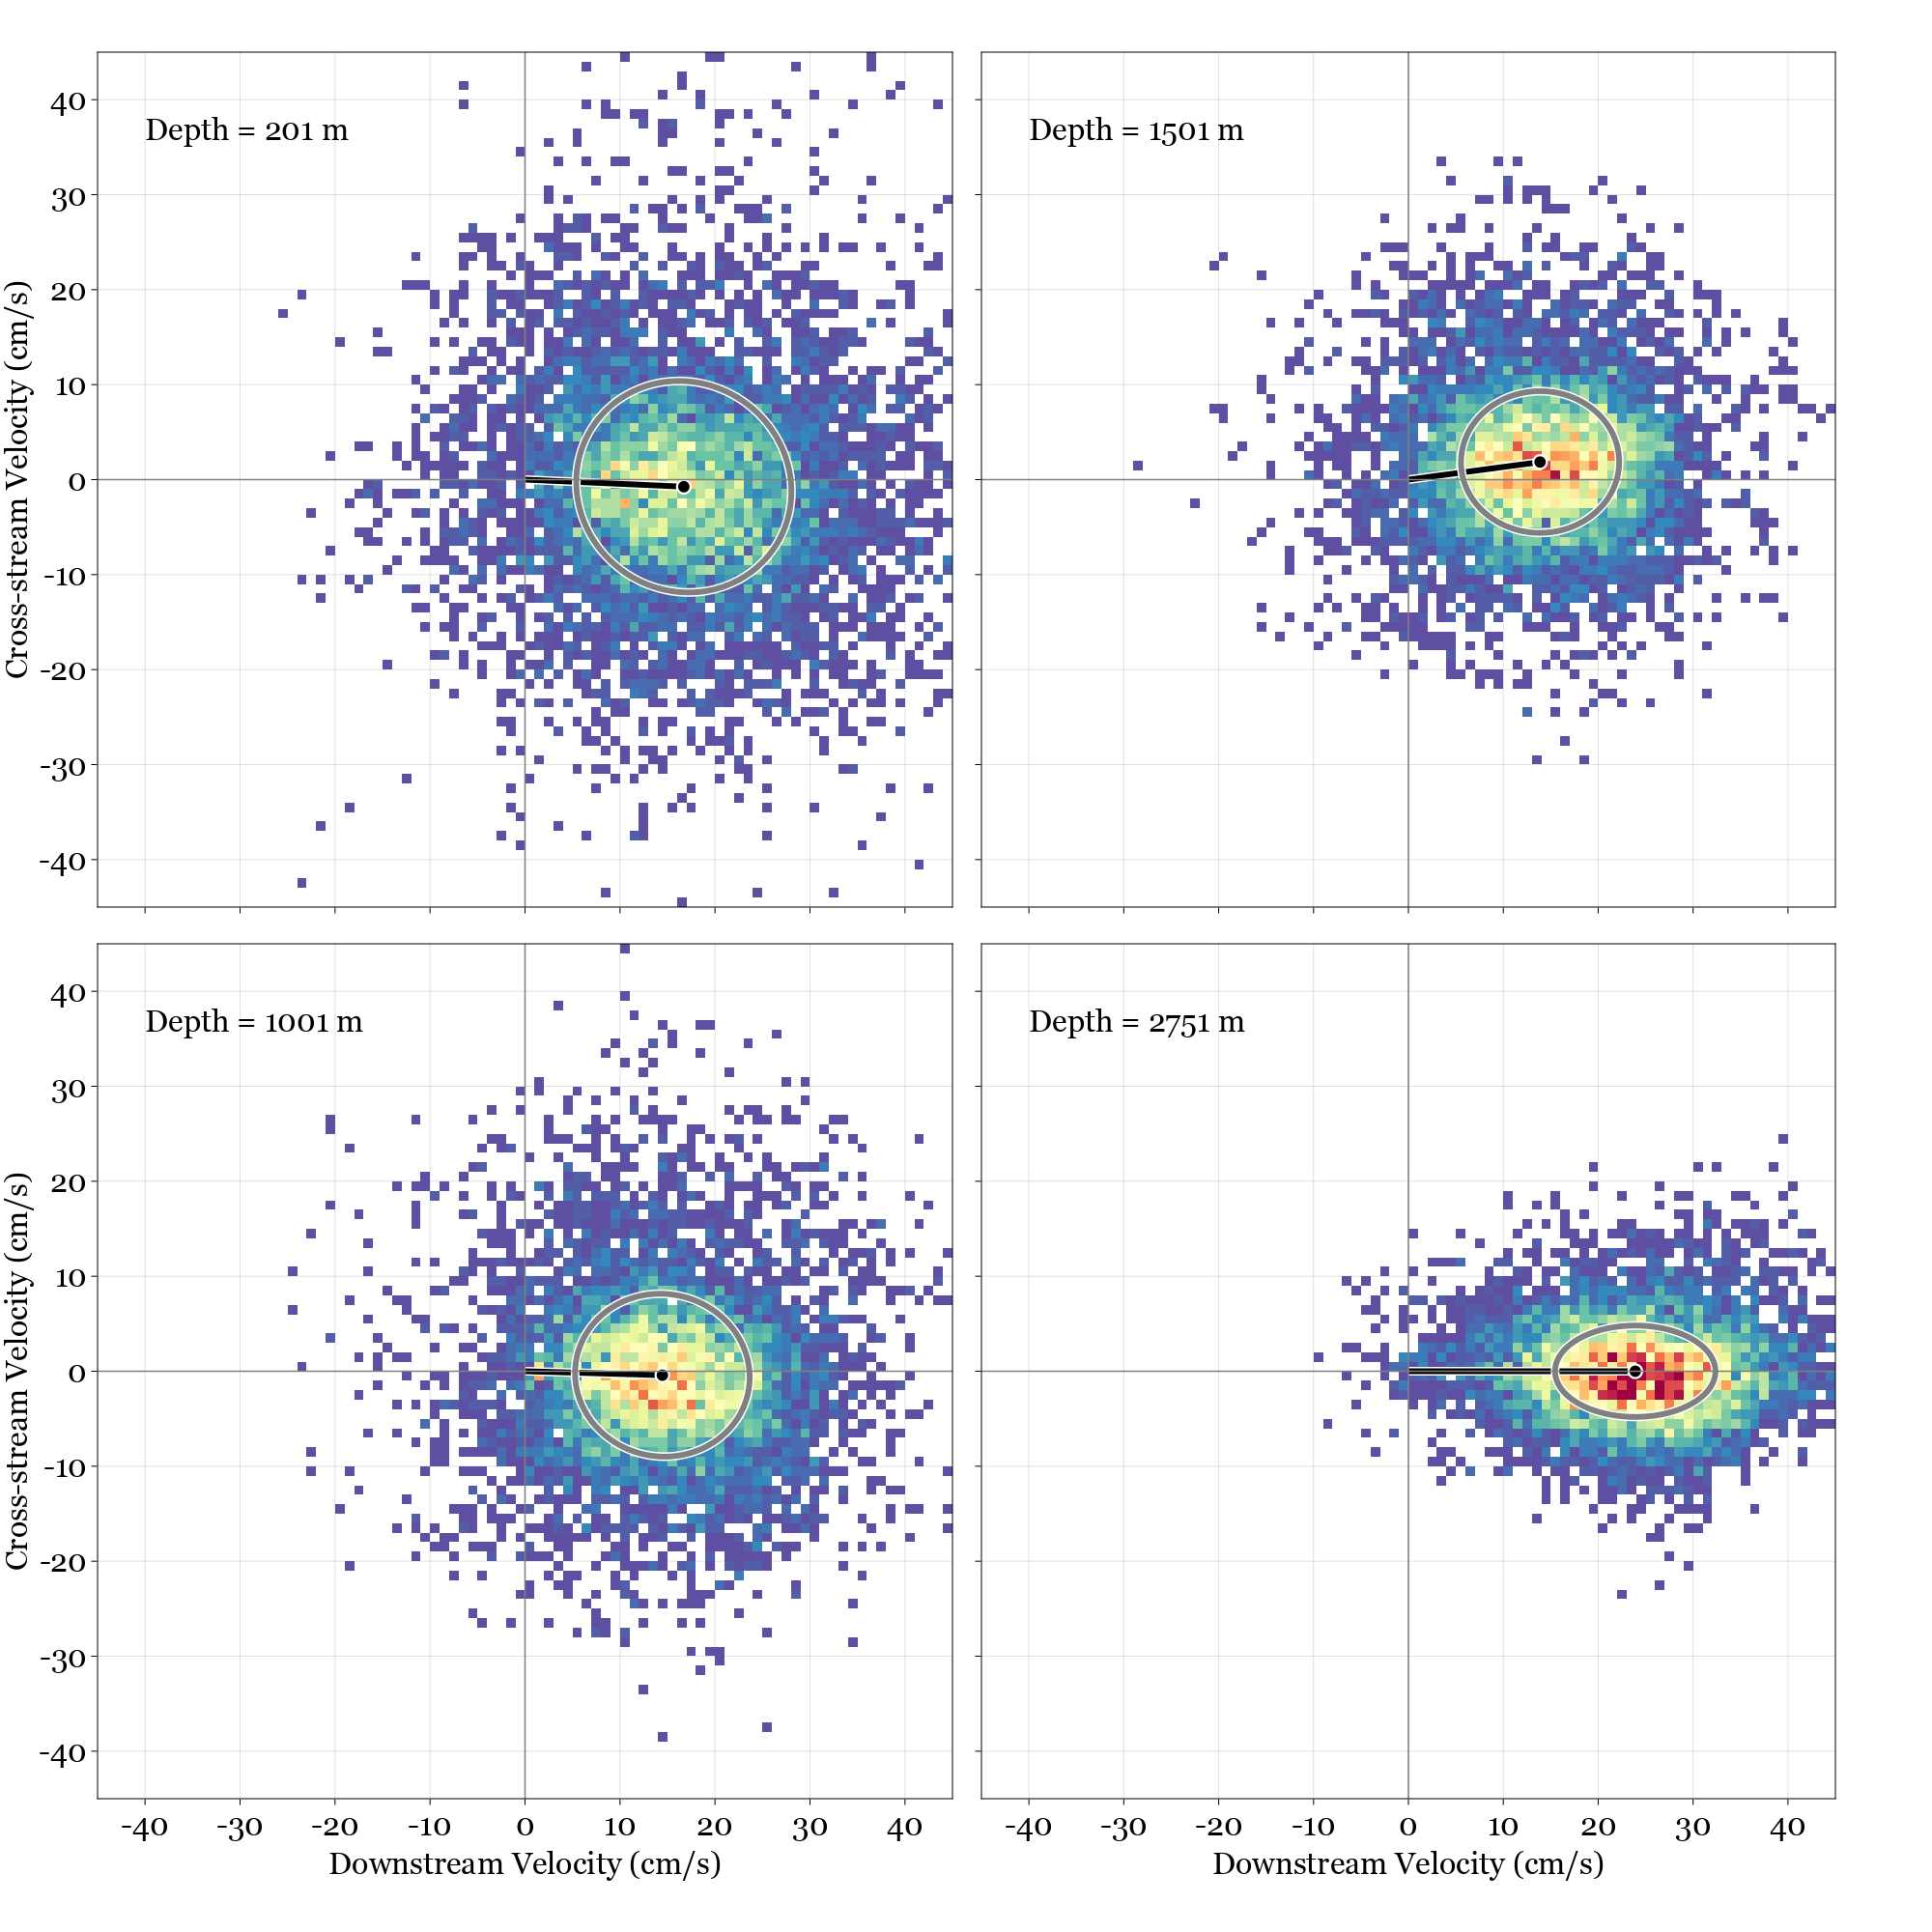

In [17]:
f = Figure(;resolution = (2000, 2000));
axs = [Axis(f[i, j], limits = (-45, 45, -45, 45)) for i in 1:2, j in 1:2]

for n = 1:size(rcv, 2)
   Σ = covmat(real(rcv[:, n]), imag(rcv[:, n]))
   a, b, θ = covdiag(Σ)
   z = ellipse.(a, b, θ, (-1:0.01:1) * pi);
   
   mat = histcounts(real.(rcv[:, n]), imag.(rcv[:, n]), xedges, yedges)
   hm = heatmap!(axs[n], mid(xedges), mid(yedges), mat', colorrange = (1, 40))
   plot_vector!(axs[n], mean(rcv[:, n])) 
   plot_ellipse!(axs[n], z, origin = mean(rcv[:, n]))
   vlines!(axs[n], 0, color = :grey); hlines!(axs[n], 0, color = :grey)

   text!(axs[n], -40, 35, text = "Depth = " * string(Integer(depths[n])) * " m")
   if n == 3 || n ==  4
        axs[n].yticklabelsvisible = false
        axs[n].ylabel = ""
    end
    if n == 1 || n ==  3
        axs[n].xticklabelsvisible = false
        axs[n].xlabel = ""
    end
end
display(f);

This shows that as we proceed down in depth, the current variability becomes increasingly anisotropic.  

Near the surface, the variabilty has no preferred orientation, and the variance ellipse is nearly ciruclar.  Moving downwards, the distribution becomes increasingly "squished" in the cross-stream direction, leading to variance ellipses elongated along the x-axis. Another way to say this is that the velocity fluctuations become increasingly *polarized* with depth. 

We can also see slight changes in the orientation of the mean flow relative to the mean flow at depth.  

# Velocity vs. Temperature Fluctuations

Let's move on now to take a look at the co-variability of temperature and velocity.  First we will make a simple time series plot. This is just the same lowpass-filtered rotated velocity signal we've been looking at, with filtered temperature at the same depth plotted underneath it.

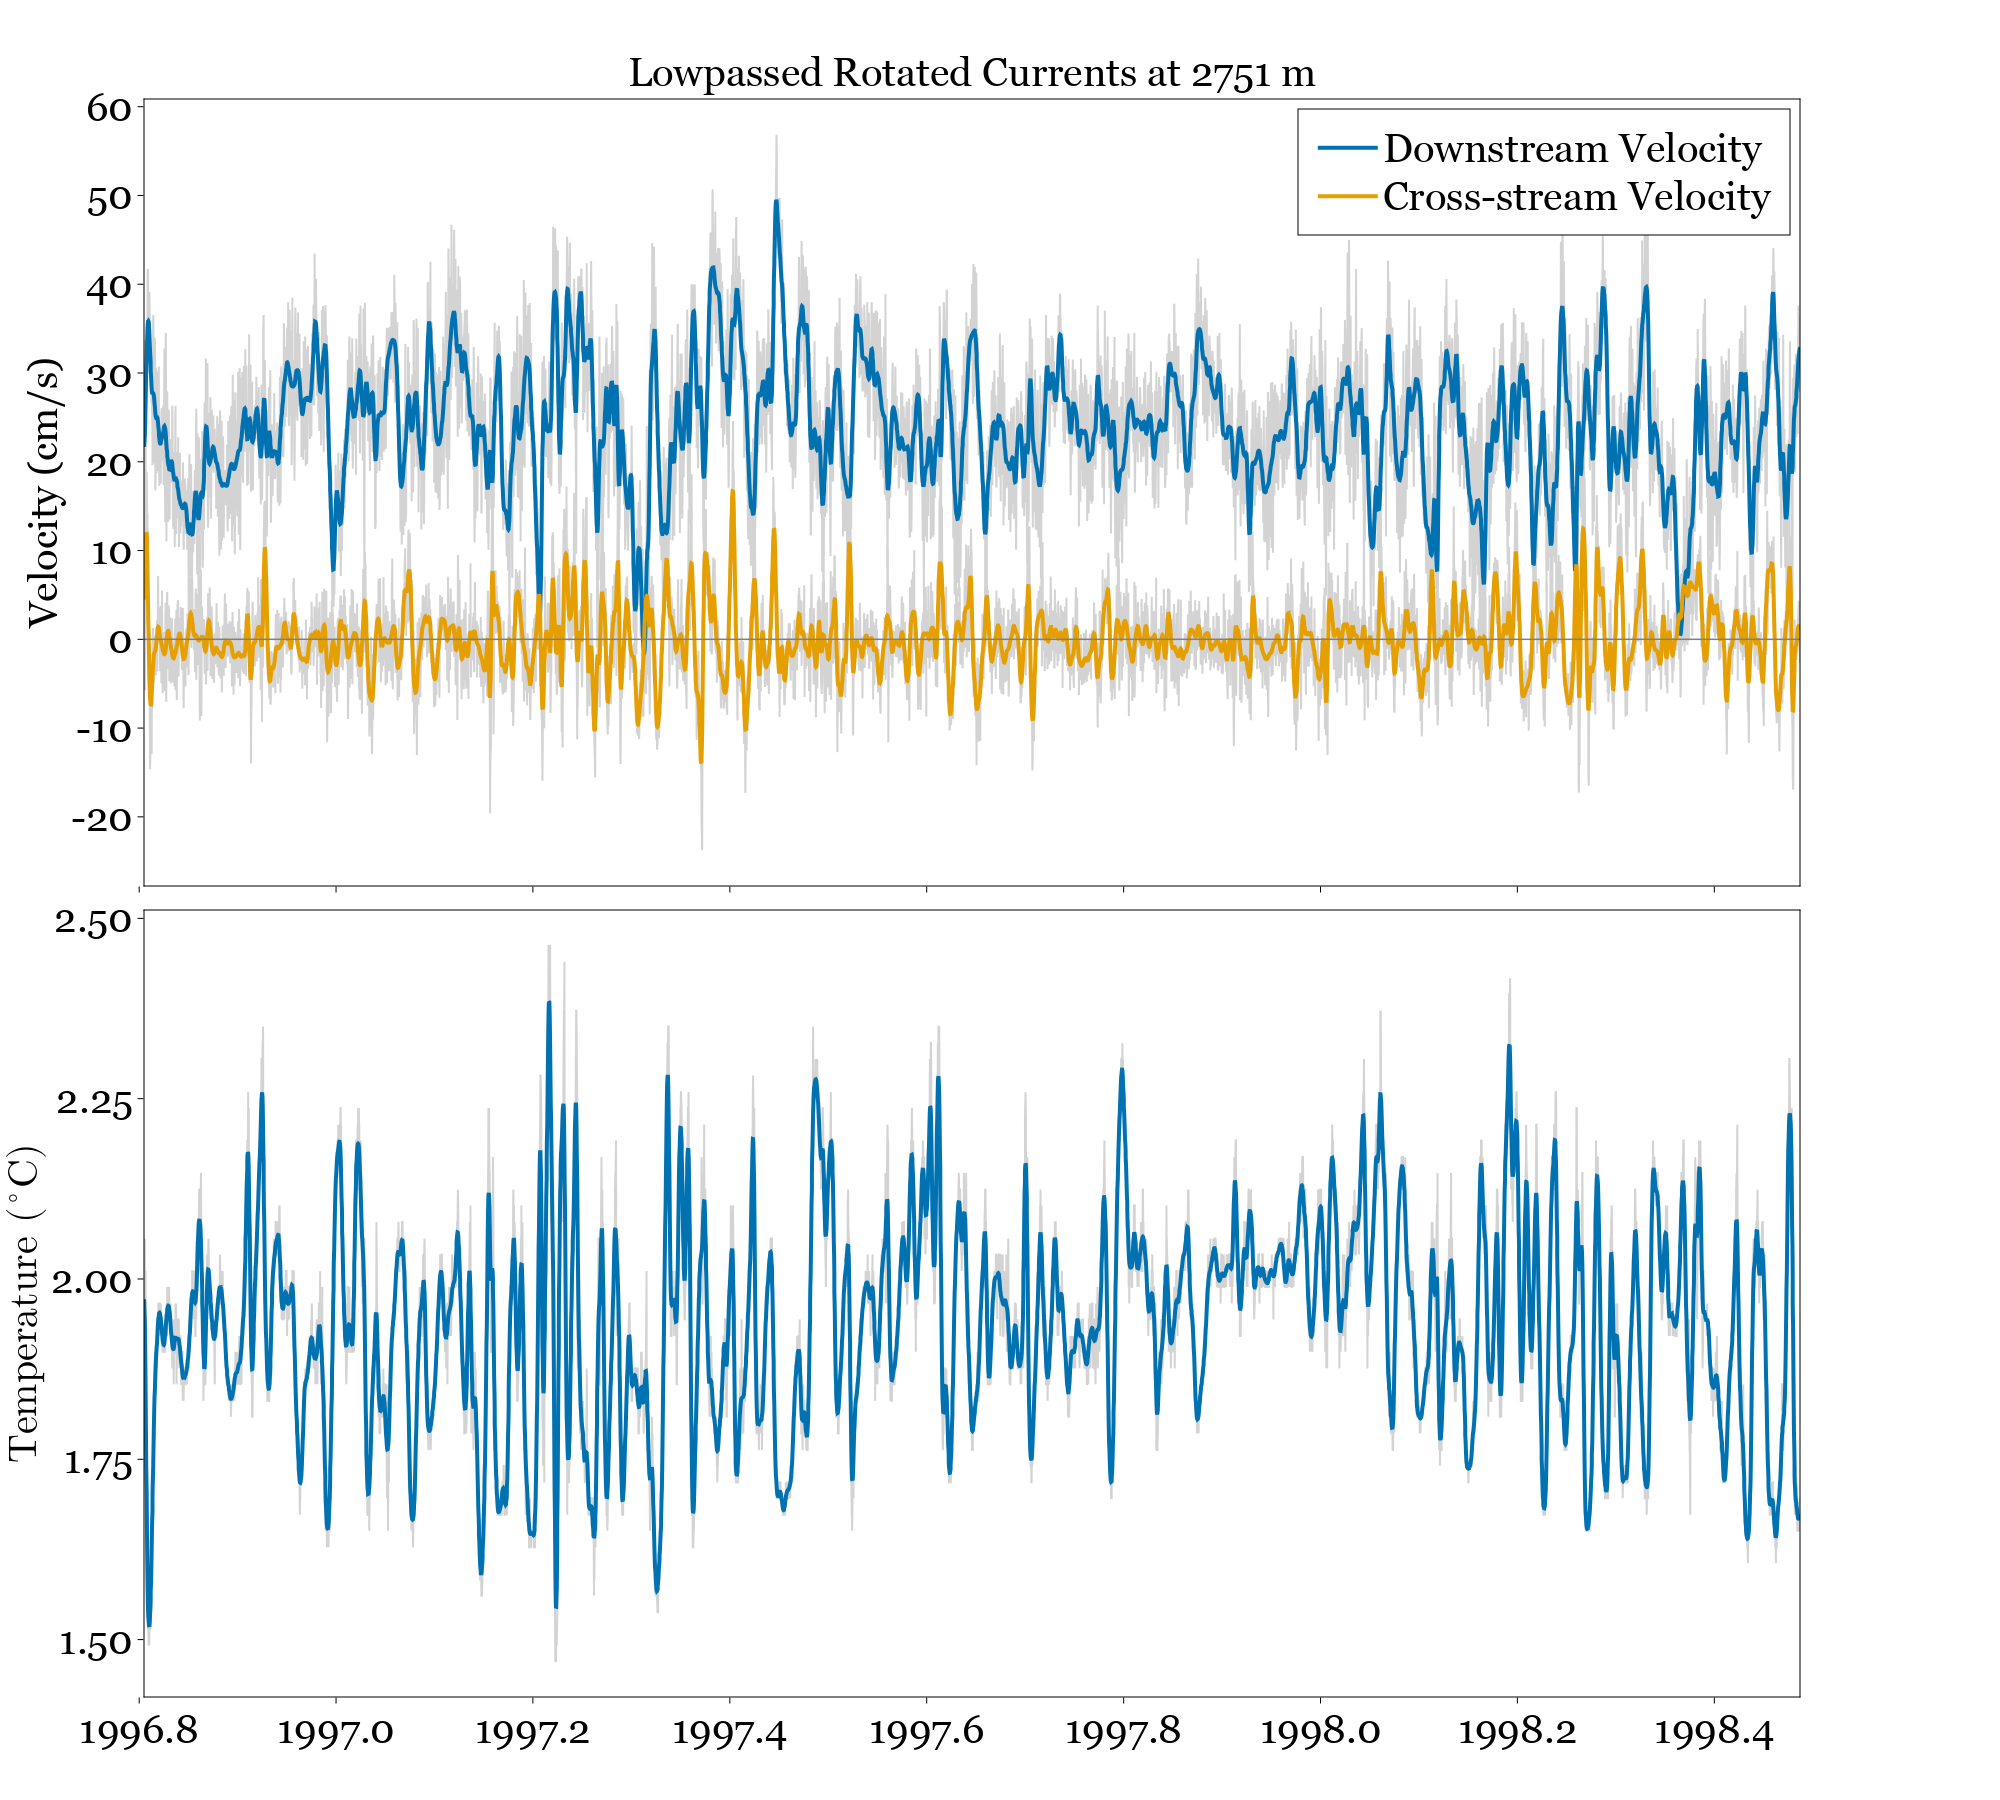

In [18]:
#create filtered version of the time series
frcv = imfilter(rcv[:,end], unitsum(hanning(24)), "reflect") 
ft = imfilter(t[:,end], unitsum(hanning(24)), "reflect") 

set_theme!(lineplottheme)
f = Figure(;resolution = (2000, 1800));
ax = Axis(f[1, 1])
lines!(yearfrac.(tim), real.(rcv[:, end]), color = :lightgrey, linewidth = 2)
lines!(yearfrac.(tim), imag.(rcv[:, end]), color = :lightgrey, linewidth = 2)
lines!(yearfrac.(tim), real.(frcv[:, end]), label = "Downstream Velocity")
lines!(yearfrac.(tim), imag.(frcv[:, end]), label = "Cross-stream Velocity")
ax.title = "Lowpassed Rotated Currents at " * string(Integer(depths[end])) * " m"
ax.ylabel = "Velocity (cm/s)";  ax.xticklabelsvisible = false
hlines!(0; color = :grey)
axislegend(ax)

ax = Axis(f[2, 1], yticks = (1:.25:3))
lines!(yearfrac.(tim),  t[:, end], color = :lightgrey, linewidth = 2)
lines!(yearfrac.(tim), ft[:, end])
ax.ylabel = L"Temperature ($^\circ$C)"
display(f);

Temperature and velocity indeed present variability on similar timescales, but it's difficult to ascertain what is going on from looking at this plot.  In particular, it's not clear whether or not there is meaningful co-variability. 

To examine this we are going to look at the two-dimensional mean of temperature $t$ as a function of the $(\tilde u, \tilde v)$ plane.  This is also known as the *conditional mean* , because the mean of $t$ is taken relative to a particular range of values of $\tilde u$ and $\tilde v$.

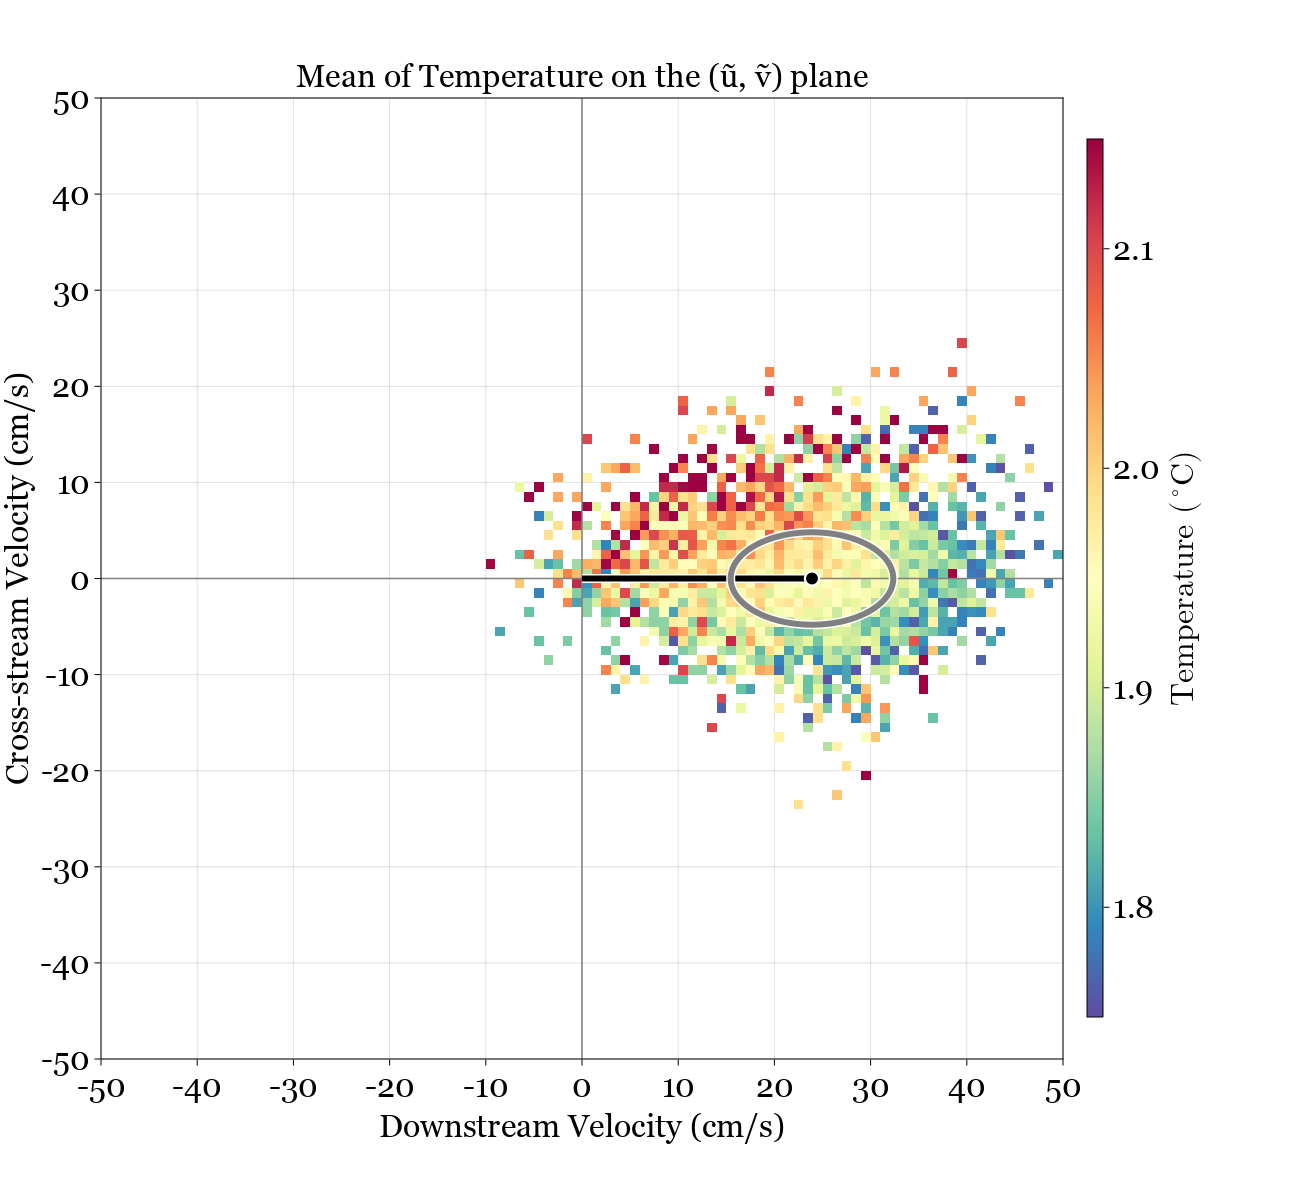

CairoMakie.Screen{IMAGE}


In [19]:
set_theme!(uvplanetheme);
f = Figure();ax = Axis(f[1, 1])
mat = nanbinmean(real.(rcv[:, end]), imag.(rcv[:, end]), t[:, end], xedges, yedges)
hm = heatmap!(mid(xedges), mid(yedges), mat', colorrange = (1.75, 2.15))
vlines!(0; color = :grey); hlines!(0; color = :grey)
plot_vector!(mean(rcv[:,end])) 
plot_ellipse!(z .+ mean(rcv[:, end]))
Colorbar(f[1, 2], hm, label = L"Temperature ($^\circ$C)")
ax.title = "Mean of Temperature on the (ũ, ṽ) plane"
display(f);
#See the Distributional Analysis lab for more 2d statistics functions

This shows that there is a definite pattern to temperature fluctuations with respect to velocity fluctuations.  Warm temperatures tend to occur when the downstream flow is weak and the cross-stream flow is in the positive direction. Cold temperatures tend to occur when the downstream flow is strong and the cross-stream flow is in the negative direction. 

The meaning of this pattern is not entirely clear, but it definitely suggests a particular relationship between the currents and temperature anomalies, perhaps associated with coherent eddies.  

Moreover, we see that there is a tendency for velocity anomalies to systematically transport heat toward the positive cross-stream direction, which as will be seen later is offshore in this case.

Note that although a relationship is clear in the 2D histogram, it does not correspond to a simple correlation with downstream or cross-stream velocity. If we simply found correlation coefficients, we would miss the details of the pattern contained in this plot. 

Let's examine the hypothesis that this pattern of temperature and velocity variability is an artifact of mooring towdown. That is, we conjecture that the mooring is going up and down due in the water column due to changes in drag, and this could interact with a pre-existing temperature gradient to generate the pattern we saw above as an artifact.

To examine this will make a plot as above, but this time with pressure as the variable we're taking the mean of. Because we don't have pressure at the deepest depth, we will substitute pressure at where we do have it, at the shallowest depth.

Note, in this next figure we are plotting the mean value of the pressure observed *at the shallowest depth* as a function of the currents observed *at the deepest depth* .

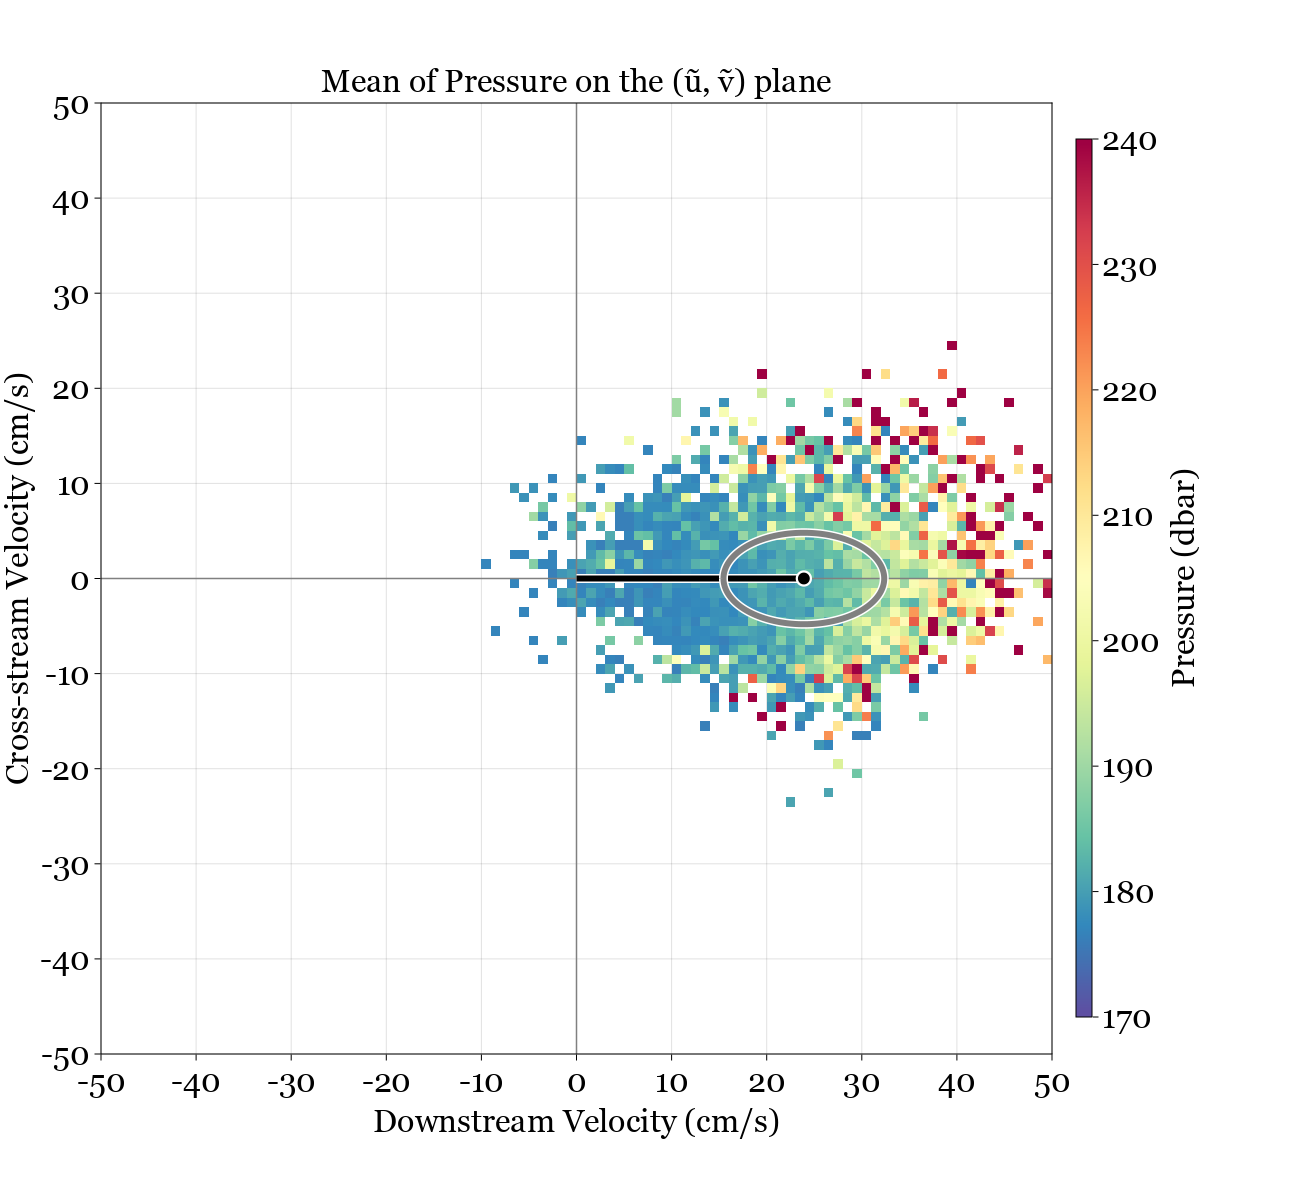

In [20]:
f = Figure();ax = Axis(f[1, 1])
mat = nanbinmean(real.(rcv[:, end]), imag.(rcv[:, end]), p[:, 1], xedges, yedges)
hm = heatmap!(mid(xedges), mid(yedges), mat', colorrange = (170, 240))
Colorbar(f[1, 2], hm, label = "Pressure (dbar)")
vlines!(0; color = :grey); hlines!(0; color = :grey)
plot_vector!(mean(rcv[:,end])) 
plot_ellipse!(z .+ mean(rcv[:, end]))
ax.title = "Mean of Pressure on the (ũ, ṽ) plane"
display(f);

This pattern is completely different. It shows that pressure is high when the speed is high, which occurs on the downstream fringe of the velocity distribution. This is just what we expect from mooring dynamics: when speeds are large, the instruments are dragged to deeper depths through the force of horizontal drag acting on the mooring line.

Indeed, had we reflected upon what the pressure should look like, we could have anticipated such a pattern. Therefore whatever is happening with the temperature is not an artifact of towdown.  Rather, it appear to be physically meaningful.

Further examination of the temperature/velocity pattern will have to wait until another time.  The point of this analysis has been to illustrate how simple plots, such as two-dimensional statistics, can be used to investigate physical hypotheses. 

# Summary Plots Using the Variance Ellipse

Now we will see how the variance ellipse can be combined with mean flow vectors to generate a summary plot.  Here, we will plot the mean flow and variance ellipse of all four instruments at this mooring superposed on the bathymetry.

For this plot you'll need [my NetCDF version](http://www.jmlilly.net/ftp/pub/sandwell.zip) version of the Smith and Sandwell one-minute global topography dataset.  See [here](http://www.jmlilly.net/doc/about_sandwell.html) for more details.

In [21]:
#Load in bathymetry data 
datadir = "/Users/lilly/Desktop/Dropbox/Matlab/jdata/sandwell/"  #your path to sandwell.nc
filename = datadir * "sandwell.nc"
#ncinfo(filename)

#Define latlon region of interest.  This is the region we will plot.
limits = (-62, -46, 52, 58.5)

#Setting a correct data aspect ratio for lat/lon plots in Makie is a little roundabout
#We'll need to compute the plotbox aspect ratio to ensure correct data aspect ratio
aspect = cosd(lat) 
plotbox_aspect = ((limits[2] - limits[1]) / (limits[4] - limits[3]))

#find indices into latlon region of interest
alon = findfirst(ncread(filename, "lon") .> limits[1])
blon = findlast(ncread(filename, "lon") .< limits[2]) 
alat = findfirst(ncread(filename, "lat") .> limits[3])
blat = findlast(ncread(filename, "lat") .< limits[4]) 

struct GeoField
    lon 
    lat
    z
end

topo = GeoField(
    ncread(filename, "lon", start = [alon], count = [blon-alon+1]), 
    ncread(filename, "lat", start = [alat], count = [blat-alat+1]), 
    -ncread(filename, "topo", start = [alat, alon], count = [blat-alat+1, blon-alon+1])
);

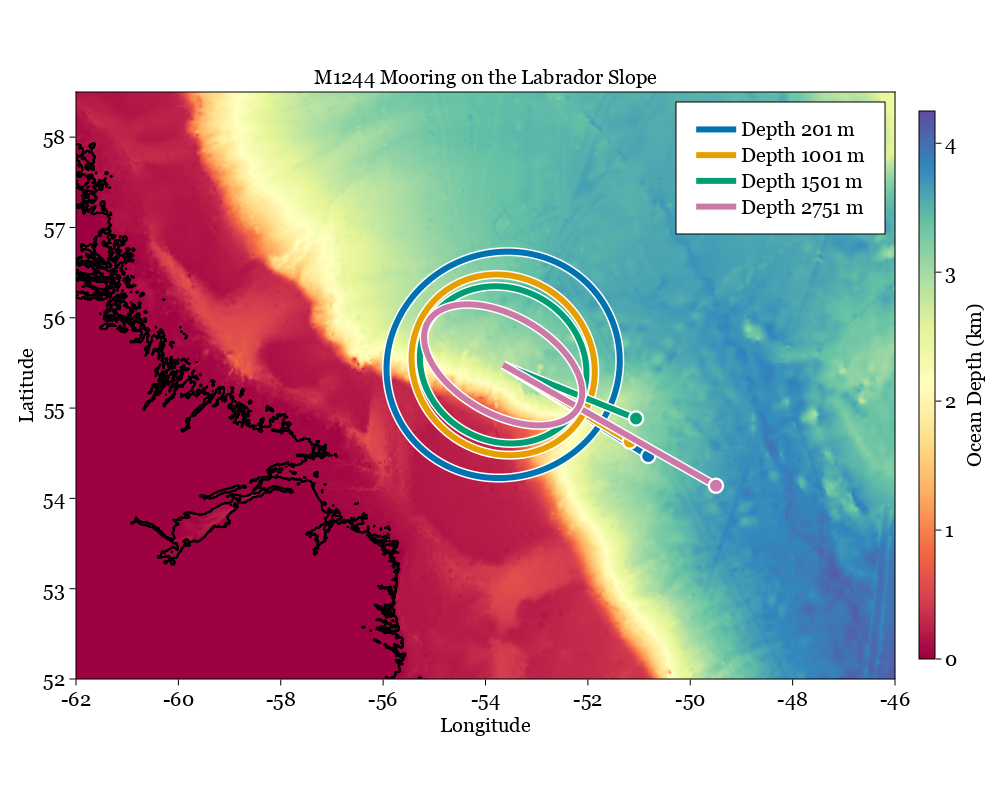

In [22]:
#Create a theme for plotting a map 
maptheme = Theme(
    Axis = (titlefont = "Georgia", limits = limits, xlabel = "Longitude", ylabel = "Latitude", 
            aspect = AxisAspect(aspect * plotbox_aspect)), #setting data aspect ratio in Makie  
    fonts = (regular = "Georgia",), fontsize = 20, 
    resolution = (1000, 800), backgroundcolor = :transparent, 
    Heatmap = (colormap = :Spectral_11,), 
    Contour = (color = :black, linewidth = 2), 
    Colorbar = (height = Relative(0.8),), 
    Legend = (merge = true, linepoints = [Point2f(-1, 0.5), Point2f(1, 0.5)], 
        padding = (40.0f0, 20.0f0, 16.0f0, 16.0f0)), 
);

set_theme!(maptheme)
f = Figure(); ax = Axis(f[1, 1])
hm = heatmap!(topo.lon, topo.lat, topo.z'; colorrange = (0, 4.25))
Colorbar(f[1, 2], hm;label = "Ocean Depth (km)")
hm = contour!(topo.lon, topo.lat, topo.z'; levels = [0])
ax.title = "M1244 Mooring on the Labrador Slope"
factor = 1/5 #scaling factor for converting cm/s into degrees; adjust for appearance
origin = lon + im * lat #origin for ellipse and vectors 

for n = 1:size(cv, 2)
    Σ = covmat(real(cv[:, n]), imag(cv[:, n]))
    a, b, θ = covdiag(Σ)
    z = ellipse.(a, b, θ, (-1:0.01:1) * pi);

    plot_vector!(factor .* mean(cv[:, n]); aspect, origin, color = Cycled(n))
    plot_ellipse!(factor .* z; aspect, origin, color = Cycled(n),
                  label = "Depth " * string(Integer(depths[n])) * " m") 
end

axislegend(ax)
display(f);

In [23]:
tock()

[ Info:         25.681301167s: 25 seconds, 681 milliseconds


Note that the mean flow is more or less aligned with the direction of the isobaths at the mooring location.  This is a not uncommon result, particularly at higher latitudes where the stratification tends to be weaker and flows are more guided by bathymetry.

Then as we progress in depth variance ellipses are seen to become increasingly constrained to be parallel to the local isobaths as well, matching the orientation of the mean flow vectors.  Again, it is fairly common (for oceanic currents, anyway) for the variance ellipse orientation to match the mean flow direction.

This plot is a good example of how the simple statitics of means and variances can be used to generate useful summaries of a whole dataset.  It also shows how those statitics become more informative when placed into some kind of context, in this case, the context of the local topography.

# The End